# Table of Contents

1. [The Problem](#The-Problem)  
2. [Overview](#Overview)   
3. [Building a Classifier](#Building-a-Classifier)  
    a. [Imports](#Classifier-Imports)  
    b. [Data Understanding](#Data-Understanding)    
    c. [Data Cleaning](#Cleaning)  
    d. [Exploratory Data Analysis](#Exploratory-Data-Analysis)  
    e. [Feature Engineering](#Feature-Engineering)  
    f. [Baseline KNN Model](#Basline-KNN-Model)  
    g. [Choosing Best Model](#Choosing-Best-Model)  
    h. [Parameter Tuning Best Model](#Parameter-Tuning-Best-Model)  
    i. [Building a Classifier Conclusion](#Building-a-Classifier-Conclusion)  
4. [Applying the Classifier](#Applying-the-Classifier)   
    a. [Imports](#Applying-Classifier-Imports)  
    a. [Time Series Analysis](#Time-Series-Analysis)  
    b. [Geographic Analysis](#Geographic-Analysis)  

# The Problem

With a central focus of climate change action, The Environmental Defense Fund (EDF) is one of the world’s leading environmental organizations. As with any non-profit, the EDF requires donations to fuel its mission. Donations and membership from individuals, specifically, make up 68% of annual support and contributions for the EDF.  Unfortunately, increasing donations can often come at a cost. According to its form 990 annual tax filings, the EDF saw a staggering 23% increase in their advertising and promotion expenses for its most recently reported year. In an effort to decrease this growth rate in the future, the EDF would like to target potential donors that are most likely to contribute. To do this, the EDF wants to know where and when its promotional efforts would yield the best results. 

# Overview

Twitter provides a vast amount of sentiment information. From this, the Environmental Defense Fund (EDF) can retrieve sentiment data in an attempt to solve the problem above. When going through this notebook, keep the following assumption in mind as it is a basis for the analysis: Donations to the EDF will rise proportionately with climate change sentiment. By completing the following two steps, the EDF will be able to make its promotional efforts more fruitful: (1) [Building a Classifier](#Building-a-Classifier): in order to do any further analysis, the EDF will require a way to classify tweets into sentiment categories for further analysis; (2) [Applying the Classifier](#Applying-the-Classifier): the classifier will be used to produce an [optimal period of time](#Time-Series-Analysis) for the EDF's promotional efforts as well as be used to [geographically target](#Geographic-Analysis) its promotional efforts. 

# Building a Classifier

## Classifier Imports

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk import word_tokenize
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from wordcloud import WordCloud
from textblob import TextBlob
import gensim
from gensim.models import Word2Vec

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import string, re
import warnings
%matplotlib inline
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['font.size'] = 20
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 1000)

In [2]:
data = pd.read_csv('./building_classifier/data/twitter_sentiment_data.csv')

Much of the code below consists of functions. If you wish to know the details of any of these functions, you can access the functions text file [here](./functions.py)

In [2]:
from functions import *

## Data Understanding

[Back to Top](#Table-of-Contents)

https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

**Description**

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo.

This dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were annotated. Each tweet is labelled independently by 3 reviewers. This dataset only contains tweets that all 3 reviewers agreed on (the rest were discarded).

Each tweet is labelled as one of the following classes:

 - 2(News): the tweet links to factual news about climate change

 - 1(Man): the tweet supports that climate change is man-made
 
 - 0(Neutral: the tweet neither supports nor refutes that climate change is man-made
 - -1(Anti): the tweet does not believe in man-made climate change

**Features**

- message: the text of the tweet
- tweetid: individual tweet identification number
- sentiment: target variable describes in more depth above

**Usage**

In the context of the EDF's problem, the focus for the classifier is on how well it can differentiate the 'Man' and 'Anti' classes. The other two classes, 'News' and 'Neutral' will remain for the purpose of creating a place for tweets that do not fit into either category. Therefore, the accuracy of the classifier will be higher. 

In [125]:
# Checking first few rows
data.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [126]:
# Checking shape
data.shape

(43943, 3)

In [127]:
# Checking for null values and datatype
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


## Cleaning

[Back to Top](#Table-of-Contents)

In [129]:
data = pd.read_csv('./building_classifier/data/twitter_sentiment_data.csv')

### Cleaning Text

The clean_tweet function serves to accomplish the following for each tweet in the dataframe:
- Remove hashtags 
- Remove hyperlinks 
- Remove mentions
- Remove retweets
- lowercase the tweet
- filter the tweet to include only letters a-z
- Convert contractions into two words

In [130]:
# Drop tweet id column 
data.drop(columns='tweetid', inplace=True)

# Clean tweets
data.message = data.message.apply(lambda data: clean_tweet(data))

# Check cleaned tweets
data.message

0        climate change is an interesting hustle as it ...
1        watch beforetheflood right here as travels the...
2        fabulous leonardo dicaprio s film on climate c...
3        fanning just watched this amazing documentary ...
4        pranita biswasi a lutheran from odisha gives t...
                               ...                        
43938    dear yeah right human mediated climate change ...
43939    what will your respective parties do to preven...
43940    un poll shows climate change is the lowest of ...
43941    i still can q t believe this gif of taehyung s...
43942    the wealthy fossil fuel industry know climate ...
Name: message, Length: 43943, dtype: object

### Lemmatization

The lemmatize_tweet function serves to accomplish the following for each tweet in the dataframe:
- Remove stopwords from tweet
- Lemmatize tweet
- Remove all words with fewer than 3 letters

In [131]:
# Lemmatize tweets
data.message = data.message.apply(lambda x: lemmatize_tweet(x))

# Check lemmatized tweets
data.head()

,sentiment,message
0,-1,climate change interesting hustle global warmi...
1,1,watch beforetheflood right travel world tackle...
2,1,fabulous leonardo dicaprio film climate change...
3,1,fanning watched amazing documentary leonardodi...
4,2,pranita biswasi lutheran odisha give testimony...


## Exploratory Data Analysis

[Back to Top](#Table-of-Contents)

In this section, I will be exloring difference aspects of the data that I believe will produce noticeable differences between the four classes.

In [3]:
data = pd.read_csv('./building_classifier/data/twitter_sentiment_data.csv')

### What is the Class Imbalance in the Dataset?

Text(0, 0.5, 'Percentage')

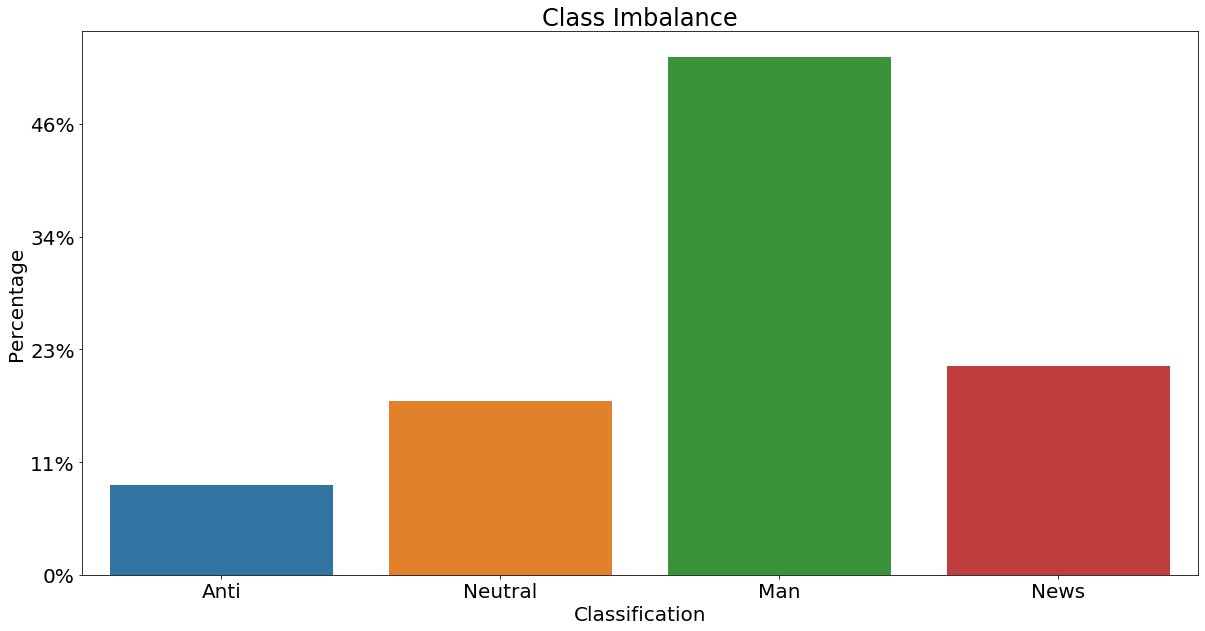

In [4]:
# Getting the length of each class subset
class_imbalance = [len(data[data.sentiment == -1]), 
                   len(data[data.sentiment == 0]), 
                   len(data[data.sentiment == 1]), 
                   len(data[data.sentiment == 2])]

# graphing class imbalance
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(class_labels, class_imbalance, ax = ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(43943))
plt.title('Class Imbalance')
plt.xlabel('Classification')
plt.ylabel('Percentage')

You can see from the graph above that there is a high level of class imbalance. Because of this, accuracy will not be a good measure of the classifier's performance in the modeling process. Furthermore, it will most likely be difficult for the model to differentiate the 'Anti' class, which means that its f1 score will be lower than that of the 'Man' class.

### Can Textblob Sentiment Analysis Reveal Differences in the Classes?

Textblob has two great built in methods that can be used for quick sentiment analysis: polarity and subjectivity

I am going to analyze each tweet using both and then plot the two sentiment analyzer against each other to better understand the relationship between these two analyzers for each class

#### Polarity

In [7]:
# creating polarity score column from Textblob polarity
data['polarity_score'] = data['message'].apply(lambda x: TextBlob(x).sentiment.polarity)

Text(0, 0.5, 'Percentage')

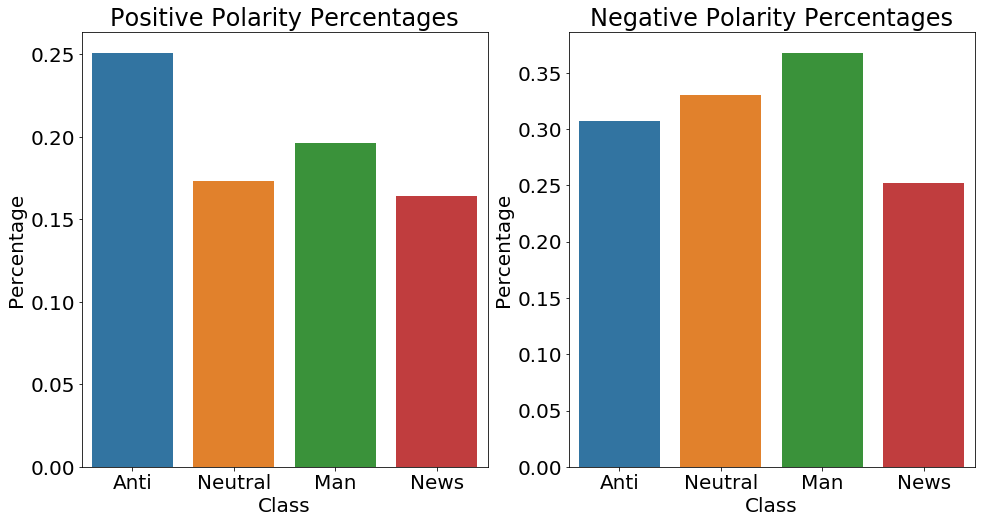

In [15]:
# Create dataframe subsets
anti = data[data.sentiment == -1]
neutral = data[data.sentiment == 0]
man = data[data.sentiment == 1]
news = data[data.sentiment == 2]

# Get percentages for below threshold
below_perc_anit = round((len(anti[anti['polarity_score'] < 0]) / len(anti)), 3)
below_perc_neutral = round((len(neutral[neutral['polarity_score'] < 0]) / len(neutral)), 3)
below_perc_man = round((len(man[man['polarity_score'] < 0]) / len(man)), 3)
below_perc_news = round((len(news[news['polarity_score'] < 0]) / len(news)), 3)

# Get percentages for above threshold
above_perc_anit = round((len(anti[anti['polarity_score'] > 0]) / len(anti)), 3)
above_perc_neutral = round((len(neutral[neutral['polarity_score'] > 0]) / len(neutral)), 3)
above_perc_man = round((len(man[man['polarity_score'] > 0]) / len(man)), 3)
above_perc_news = round((len(news[news['polarity_score'] > 0]) / len(news)), 3)

#Plotting positive and negative polarity
fig, (ax1, ax2) = plt.subplots(1,2)
sns.barplot(class_labels, [below_perc_anit, below_perc_neutral, below_perc_man, below_perc_news], ax=ax1)
sns.barplot(class_labels, [above_perc_anit, above_perc_neutral, above_perc_man, above_perc_news], ax=ax2)
ax1.set_title('Positive Polarity Percentages')
ax1.set_xlabel('Class')
ax1.set_ylabel('Percentage')
ax2.set_title('Negative Polarity Percentages')
ax2.set_xlabel('Class')
ax2.set_ylabel('Percentage')

From the graphs above, we can see that the 'Anti' class stands out for positive polarity and the 'Man' class stands out in negative polarity

#### Subjectivity

In [13]:
# creating subjectivity score column from Textblob subjectivity
data['subjectivity_score'] = data['message'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

Text(0, 0.5, 'Percentage')

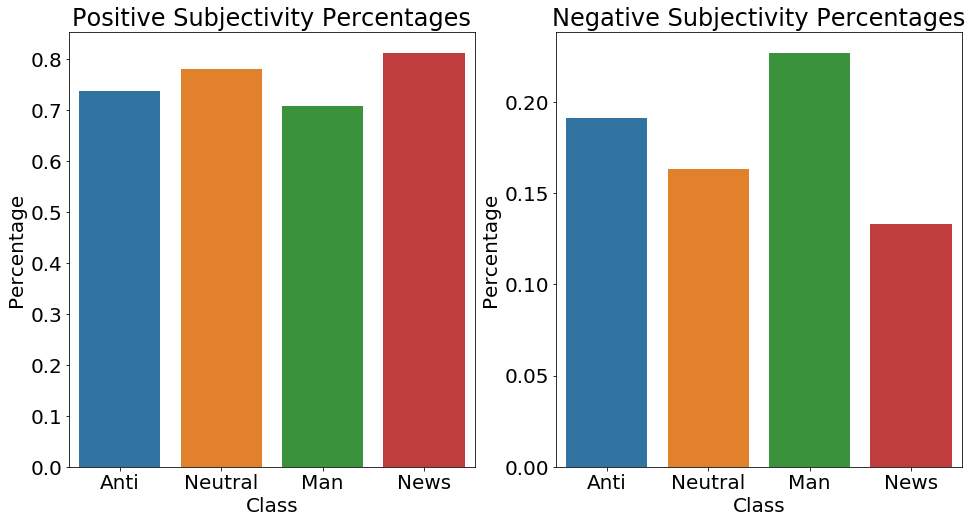

In [17]:
# Create dataframe subsets
anti = data[data.sentiment == -1]
neutral = data[data.sentiment == 0]
man = data[data.sentiment == 1]
news = data[data.sentiment == 2]

# Get percentages for below threshold
below_perc_anit = round((len(anti[anti['subjectivity_score'] < 0.5]) / len(anti)), 3)
below_perc_neutral = round((len(neutral[neutral['subjectivity_score'] < 0.5]) / len(neutral)), 3)
below_perc_man = round((len(man[man['subjectivity_score'] < 0.5]) / len(man)), 3)
below_perc_news = round((len(news[news['subjectivity_score'] < 0.5]) / len(news)), 3)

# Get percentages for above threshold
above_perc_anit = round((len(anti[anti['subjectivity_score'] > 0.5]) / len(anti)), 3)
above_perc_neutral = round((len(neutral[neutral['subjectivity_score'] > 0.5]) / len(neutral)), 3)
above_perc_man = round((len(man[man['subjectivity_score'] > 0.5]) / len(man)), 3)
above_perc_news = round((len(news[news['subjectivity_score'] > 0.5]) / len(news)), 3)

#Plotting positive and negative polarity
fig, (ax1, ax2) = plt.subplots(1,2)
sns.barplot(class_labels, [below_perc_anit, below_perc_neutral, below_perc_man, below_perc_news], ax=ax1)
sns.barplot(class_labels, [above_perc_anit, above_perc_neutral, above_perc_man, above_perc_news], ax=ax2)
ax1.set_title('Positive Subjectivity Percentages')
ax1.set_xlabel('Class')
ax1.set_ylabel('Percentage')
ax2.set_title('Negative Subjectivity Percentages')
ax2.set_xlabel('Class')
ax2.set_ylabel('Percentage')

Based on the graphs above, subjectivity scores will likely only aid in the identification of the 'News' class

### Is Tweet Length Different Between the Classes?

Here, I am taking the median length tweet for each class. I do not expect to see much of a difference between the classes here.

Text(0, 0.5, 'Median')

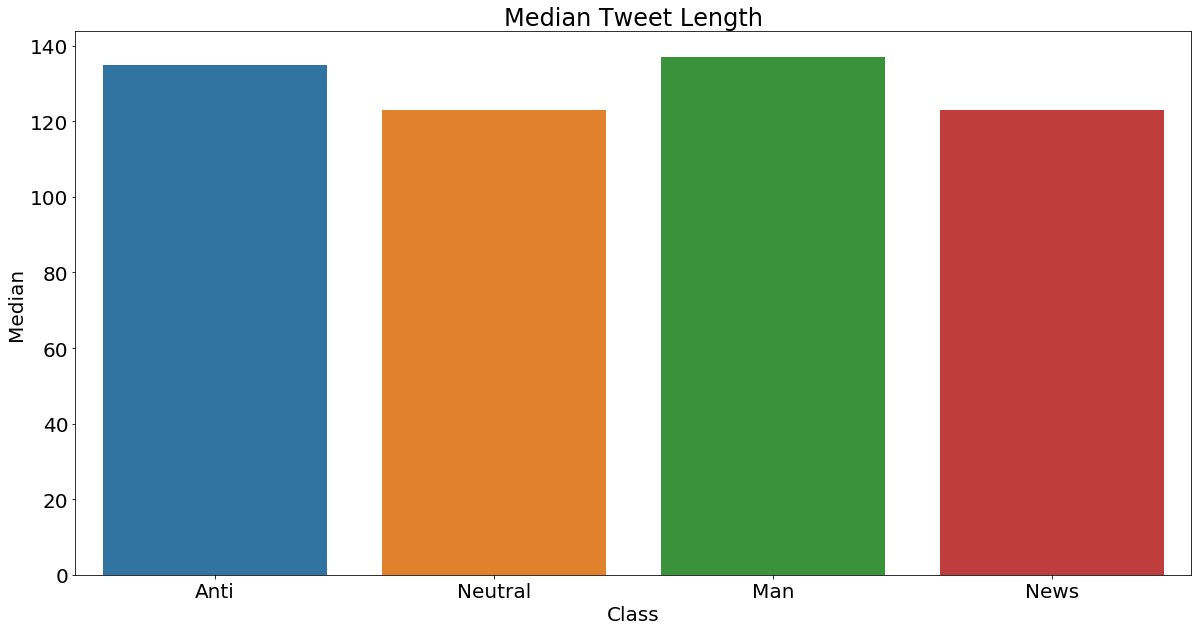

In [20]:
# Creating tweet length column
data['text_length'] = data['message'].apply(lambda x: len(x))

# Resetting class subsets to include new column
anti = data[data.sentiment == -1]
neutral = data[data.sentiment == 0]
man = data[data.sentiment == 1]
news = data[data.sentiment == 2]

# Getting median tweet length for each class
avg_length_anti = anti.text_length.median()
avg_length_neutral = neutral.text_length.median()
avg_length_man = man.text_length.median()
avg_length_news = news.text_length.median()

# Specifying y-values
length_medians = (avg_length_anti, avg_length_neutral, avg_length_man, avg_length_news)

# Building graph
plt.figure(figsize=(20,10))
sns.barplot(class_labels, length_medians)
plt.title('Median Tweet Length')
plt.xlabel('Class')
plt.ylabel('Median')

There is actually a small difference between the class. You can see above that the "Anti Man-Made" and "Man-Made" classes are similar in length while the "Neutral" and "News" classes are also similar in length.

### Wordclouds

Because this is an NLP project, it is paramount to understand the word frequency differences across classes. In order to observe this, I will create wordclouds for each class

In [22]:
cloud = pd.read_csv('./building_classifier/data/twitter_sentiment_data.csv')

In [23]:
# Set cloud equal to dataframe 
cloud = data

# Clean and lemmatize tweets
cloud.message = cloud.message.apply(lambda x: clean_tweet(x))
cloud.message = cloud.message.apply(lambda x: lemmatize_tweet(x))

In [24]:
# Subsetting cloud dataframe by class
cloud_anti = cloud[cloud.sentiment == -1]
cloud_neutral = cloud[cloud.sentiment == 0]
cloud_man = cloud[cloud.sentiment == 1]
cloud_news = cloud[cloud.sentiment == 2]

# Turn all messages in each subset into single string
message_anti = " ".join(review for review in cloud_anti.message)
message_neutral = " ".join(review for review in cloud_neutral.message)
message_man = " ".join(review for review in cloud_man.message)
message_news = " ".join(review for review in cloud_news.message)

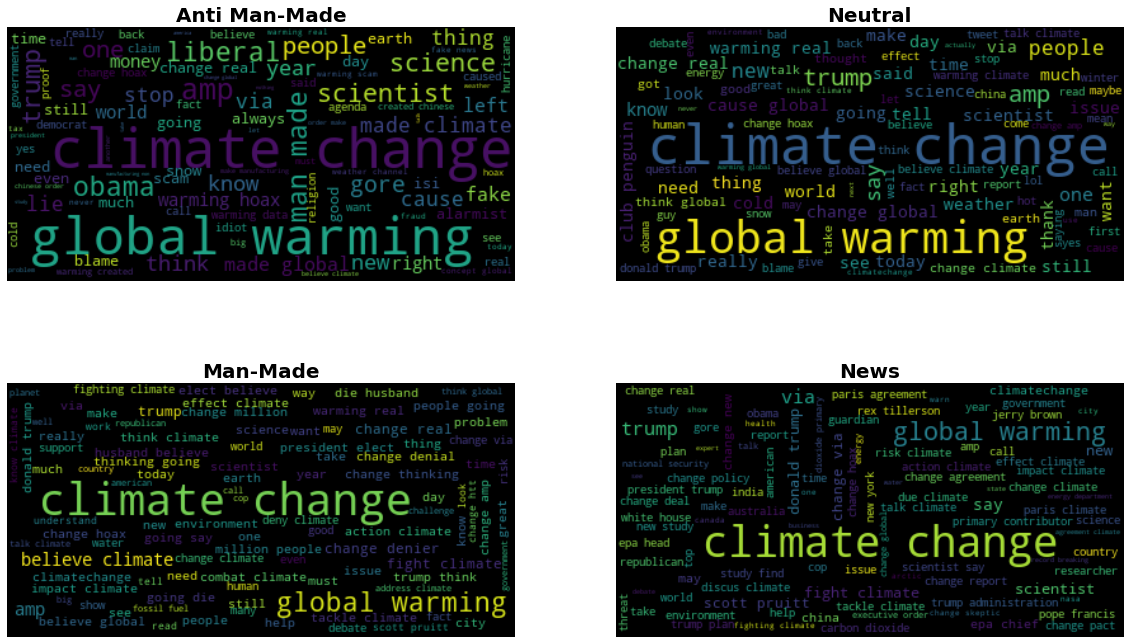

In [25]:
# Plot wordclouds
wordcloud_anti = WordCloud(background_color="black", max_words = 100).generate(message_anti)
wordcloud_neutral = WordCloud(background_color="black", max_words = 100).generate(message_neutral)
wordcloud_man = WordCloud(background_color="black", max_words = 100).generate(message_man)
wordcloud_news = WordCloud(background_color="black", max_words = 100).generate(message_news)

fig, ax = plt.subplots(2,2, figsize=(20,12))

ax[0,0].imshow(wordcloud_anti, interpolation='bilinear')
ax[0,0].axis("off")
ax[0,0].set_title('Anti Man-Made', fontsize=20, fontweight='bold')
ax[0,1].imshow(wordcloud_neutral, interpolation='bilinear')
ax[0,1].axis("off")
ax[0,1].set_title('Neutral', fontsize=20, fontweight='bold')
ax[1,0].imshow(wordcloud_man, interpolation='bilinear')
ax[1,0].axis("off")
ax[1,0].set_title('Man-Made', fontsize=20, fontweight='bold')
ax[1,1].imshow(wordcloud_news, interpolation='bilinear')
ax[1,1].axis("off")
ax[1,1].set_title('News', fontsize=20, fontweight='bold')

plt.show()

There is nothing notable to glean from the graphs above. As you can see, there are only minute differences between the wordclouds of each class.

### How Does the Presence of Certain Elements Differ Between the Classes?

I will be specifically looking into the presence and number of following elements:

- Hyperlinks (just presence)
- Retweets (just presence)
- Mentions (presence and number)
- Hashtags (presence and number)

#### Hyperlinks

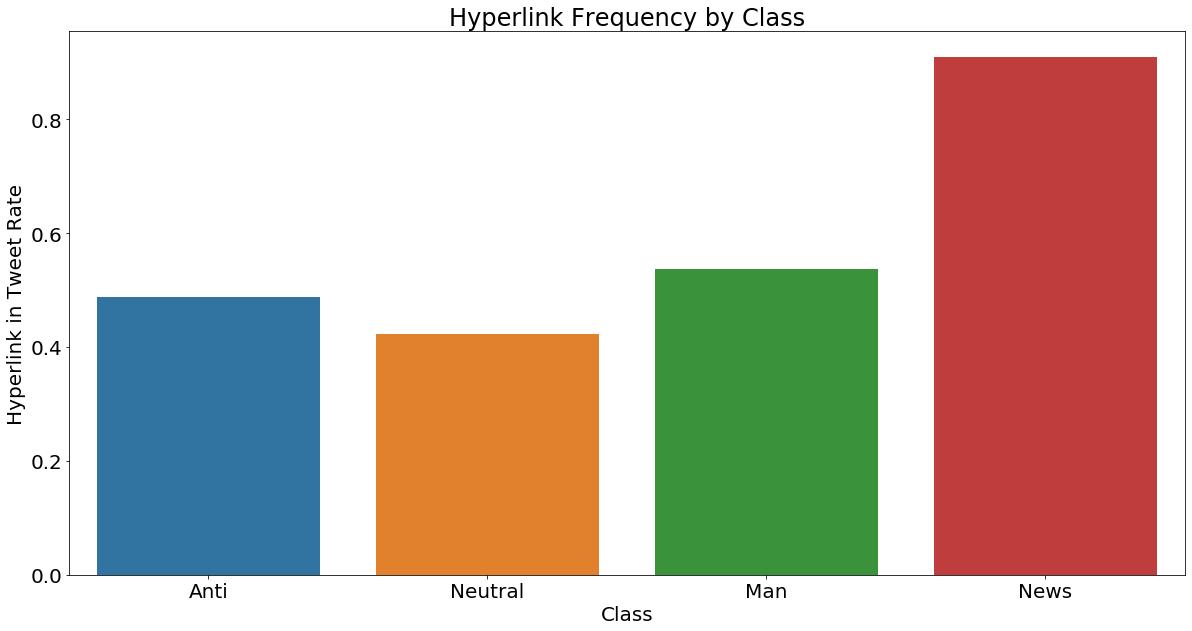

In [4]:
element_present_plot('hyperlink_present','http','Hyperlink')

The graphs shows what you might expect. "News" tweets would likely link to an article of external source. A link appears in about 90% of all "News" tweets.

#### Retweets

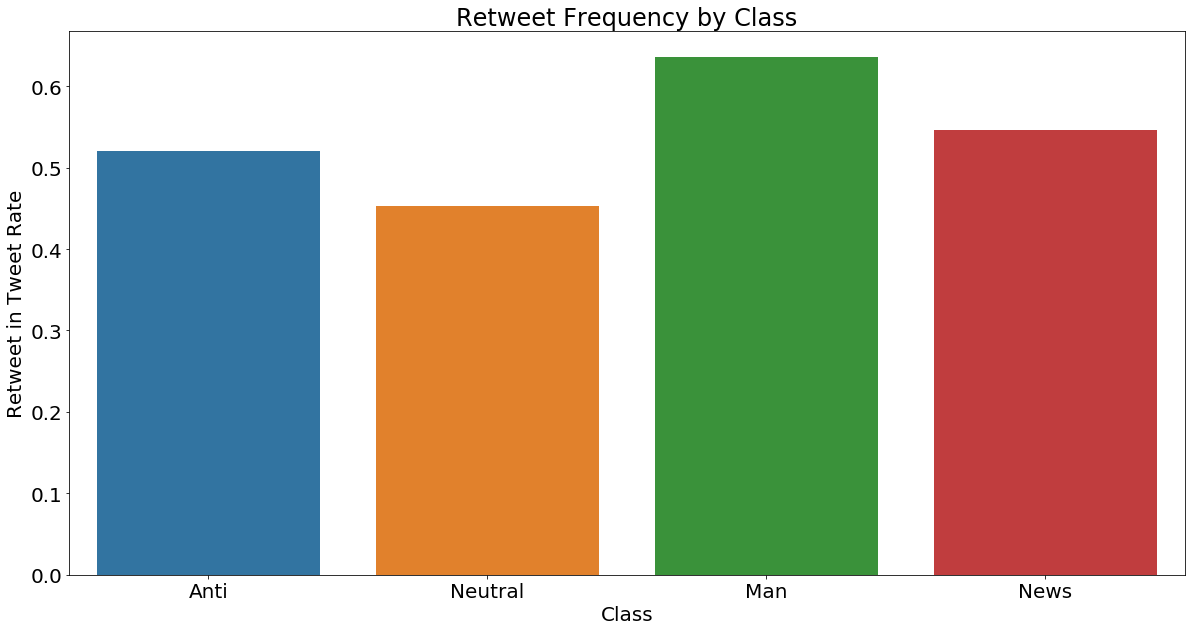

In [5]:
element_present_plot('retweet_present','RT','Retweet')

I wasn't sure what to expect from this. I think a possible conclusion is that there are just more "Man-Man" supporters out there, so the opportunity to retweet is greater. 

#### Mentions

##### Mentions Present

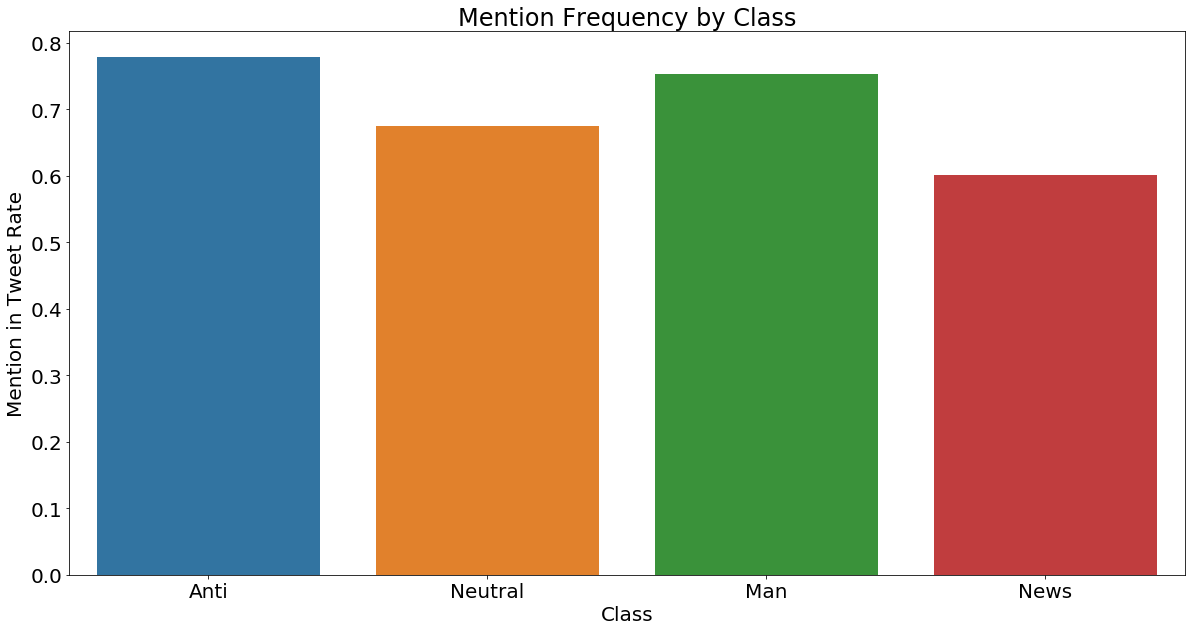

In [6]:
element_present_plot('mention_present', '@','Mention')

I noticed while combing through the data that some tweets are just out there for attention. These tweets tends to take very strong stances on subjects and sometimes have 20+ mentions. These particular tweets are deploying a tactic that helps them get noticed.

##### Number of Mentions

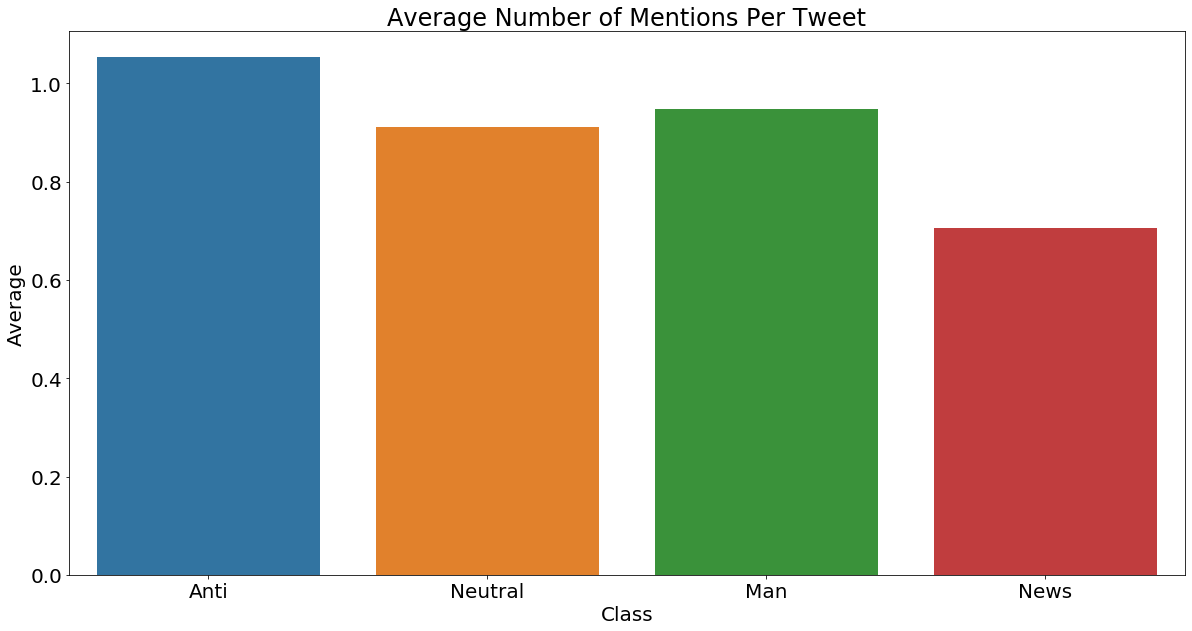

In [7]:
element_count_plot('mention_count', '@','Mention')

About the same results as above. No further conclusions drawn

#### Hashtags

##### Hashtag Present

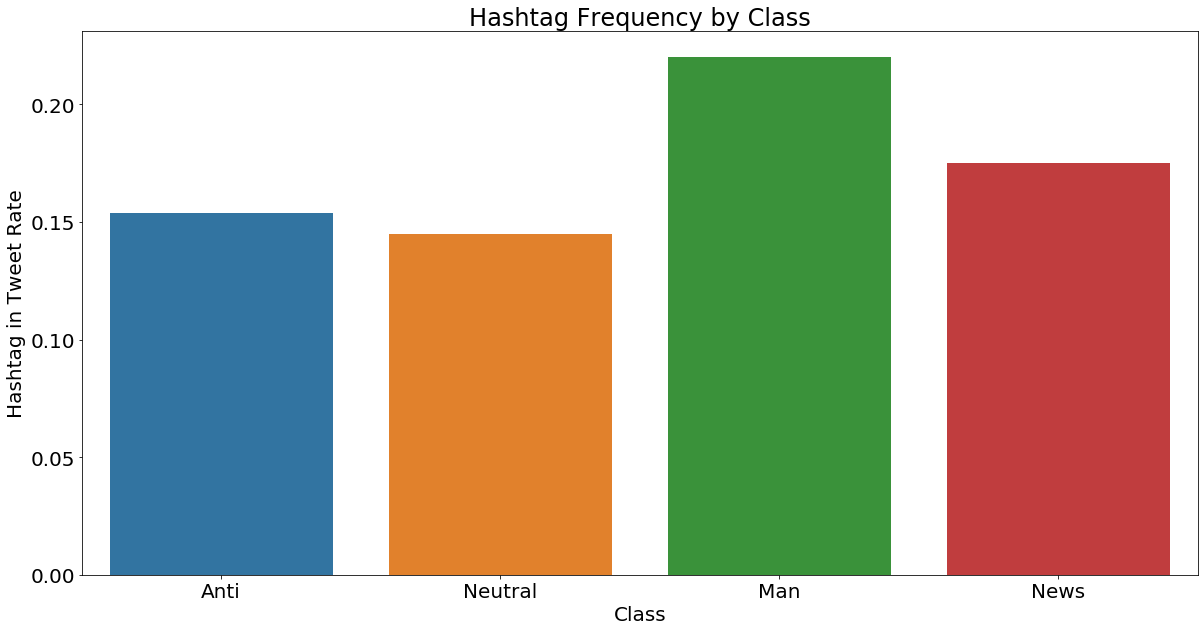

In [8]:
element_present_plot('hashtag_present', '#','Hashtag')

Interesting to see this. Will see whether including this in the modeling process produces any noticeable results

##### Number of Hashtags

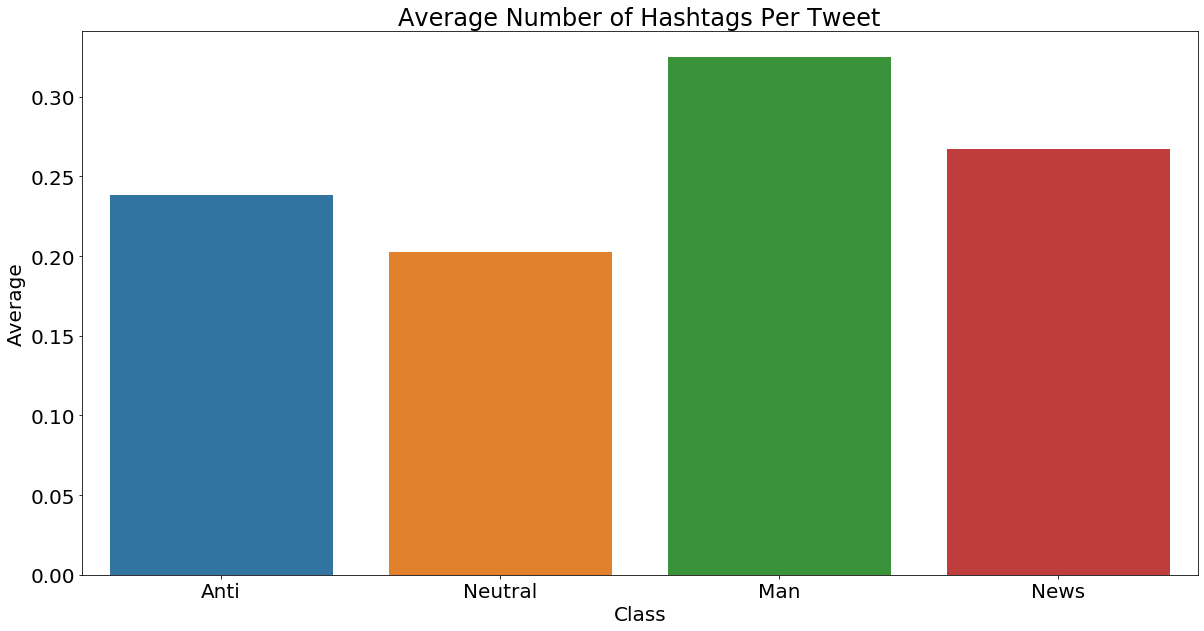

In [9]:
element_count_plot('hashtag_count', '#','Hashtag')

No further conclusions drawn

### Punctuation

I knew that punctuation would be a good thing to look into because it would definitely separate out "News" tweets. I went with punctuation that could be considered more rare in the scope of ordinary typed-speech. 

#### Exclamation Point

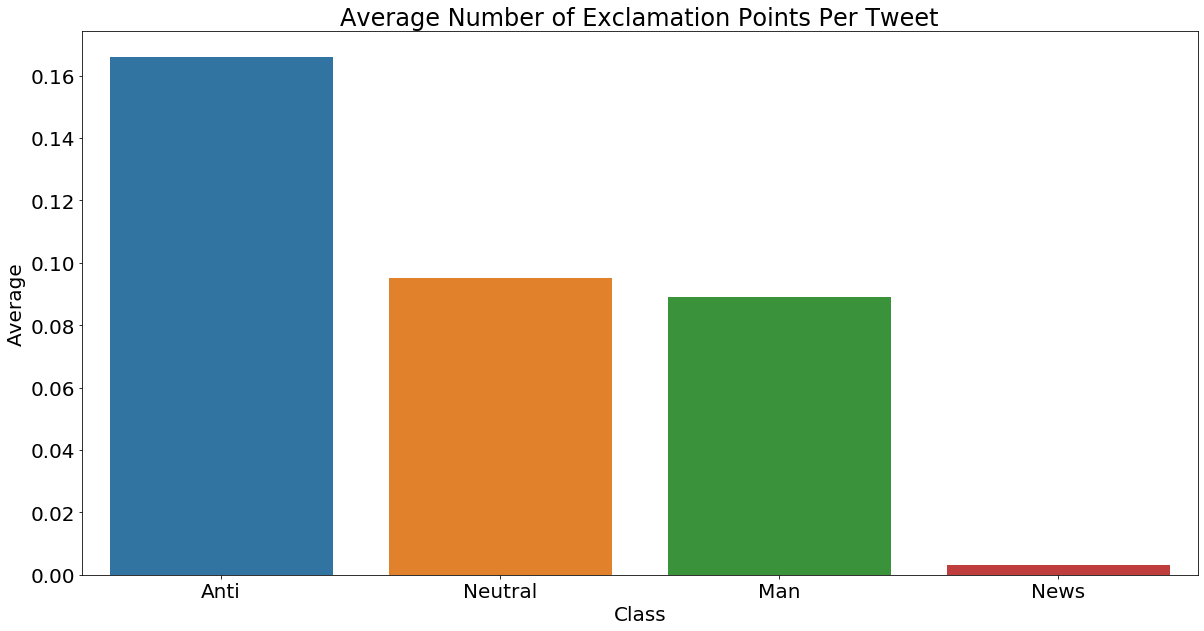

In [10]:
element_count_plot('exclamation_point_count','!','Exclamation Point')

Huge difference is the presence of quesiton marks. The "News" class has almost none, which will be very helpful for modeling

#### Question Mark

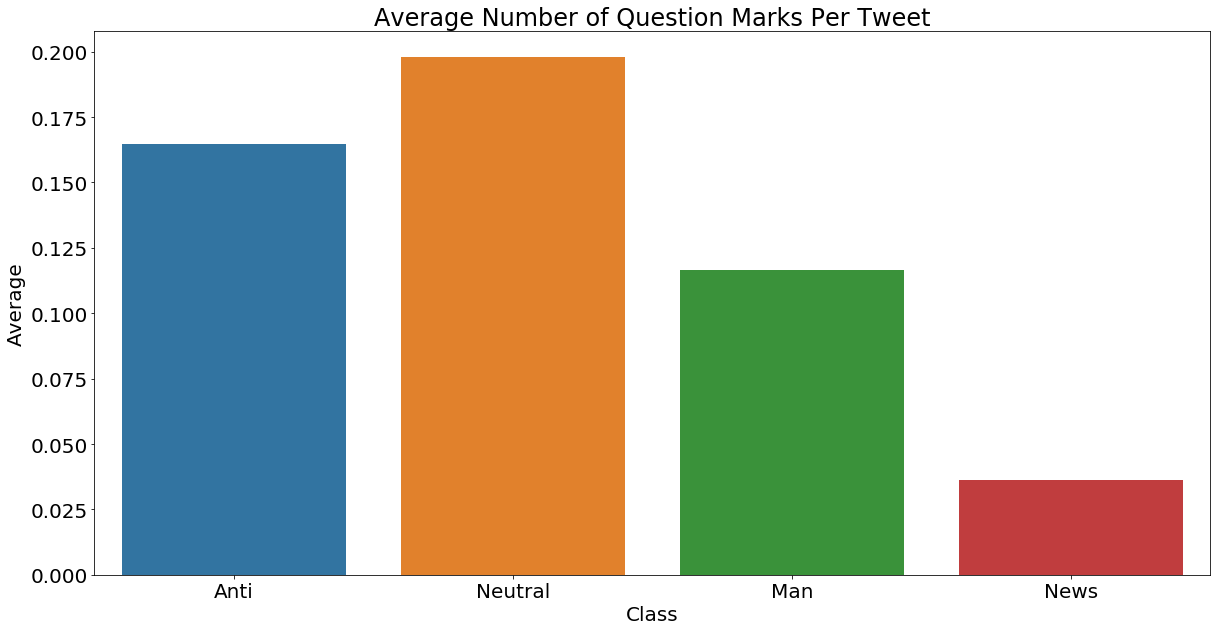

In [11]:
element_count_plot('question_mark_count','?','Question Mark')

Once again, the "News" class has very few

#### Dollar Sign

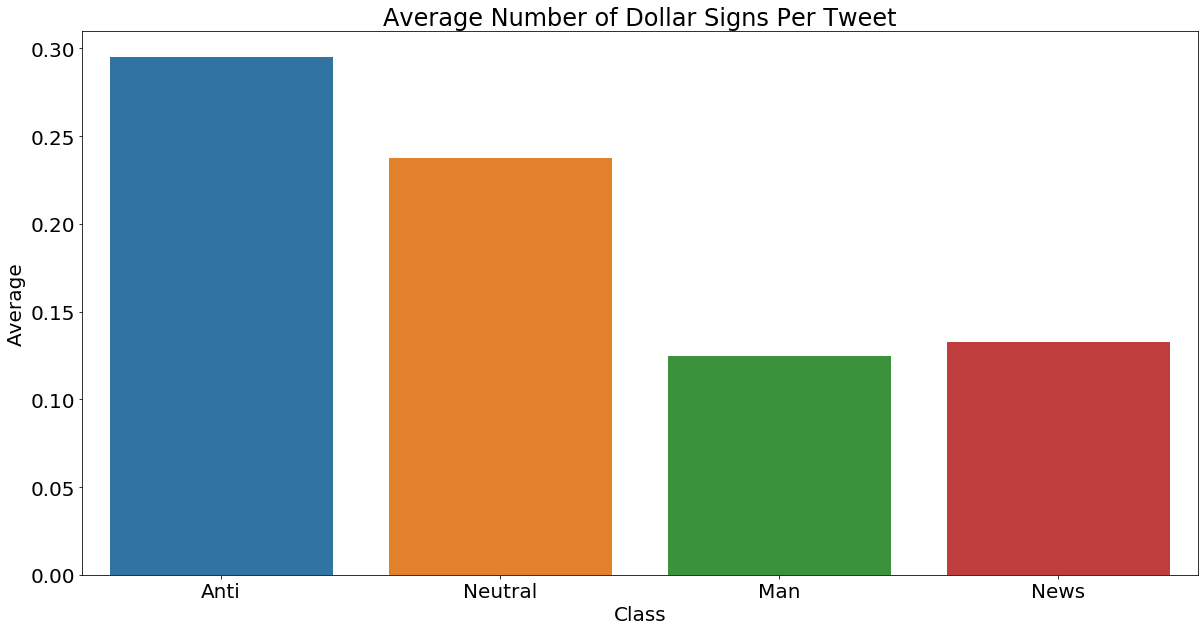

In [12]:
element_count_plot('dollar_sign_count','$','Dollar Sign')

I believe that this is as a result of the following: one of the biggest arguments against action for climate change is that it is expensive and will lower jobs. A deeper dive into this may be helpful.

#### Percent Symbol

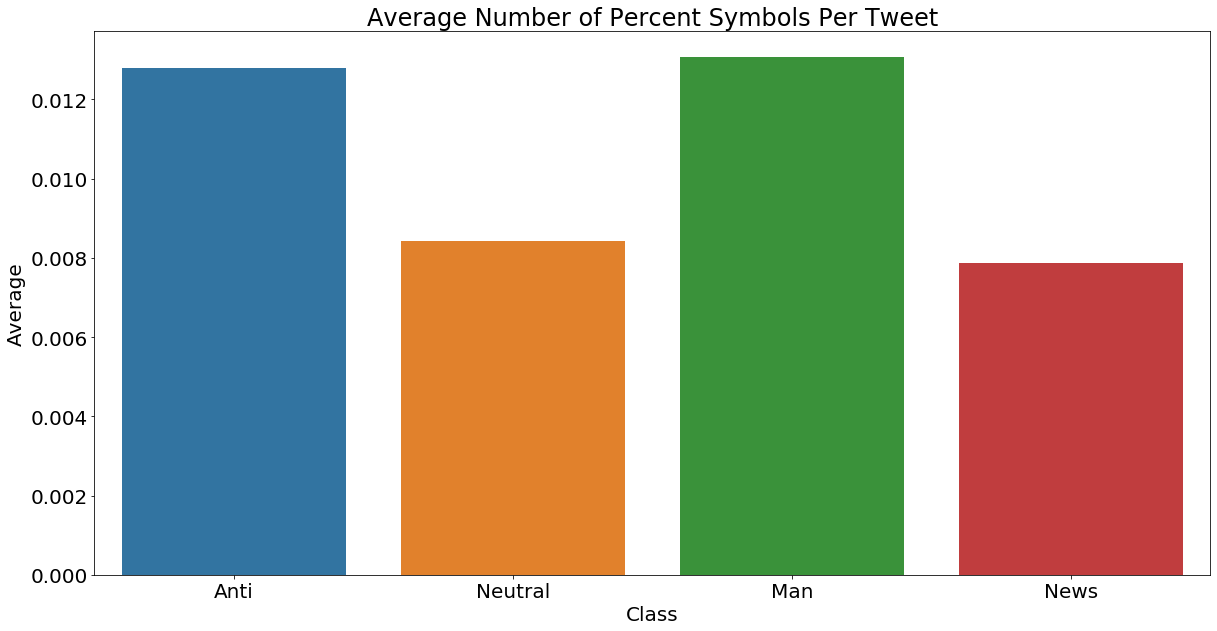

In [13]:
element_count_plot('percent_symbol_count','%','Percent Symbol')

This may be the result of people quoting statistics. The graphs are starting to show that the "Neutral" class possesses less emotion in its tweets

#### Colon

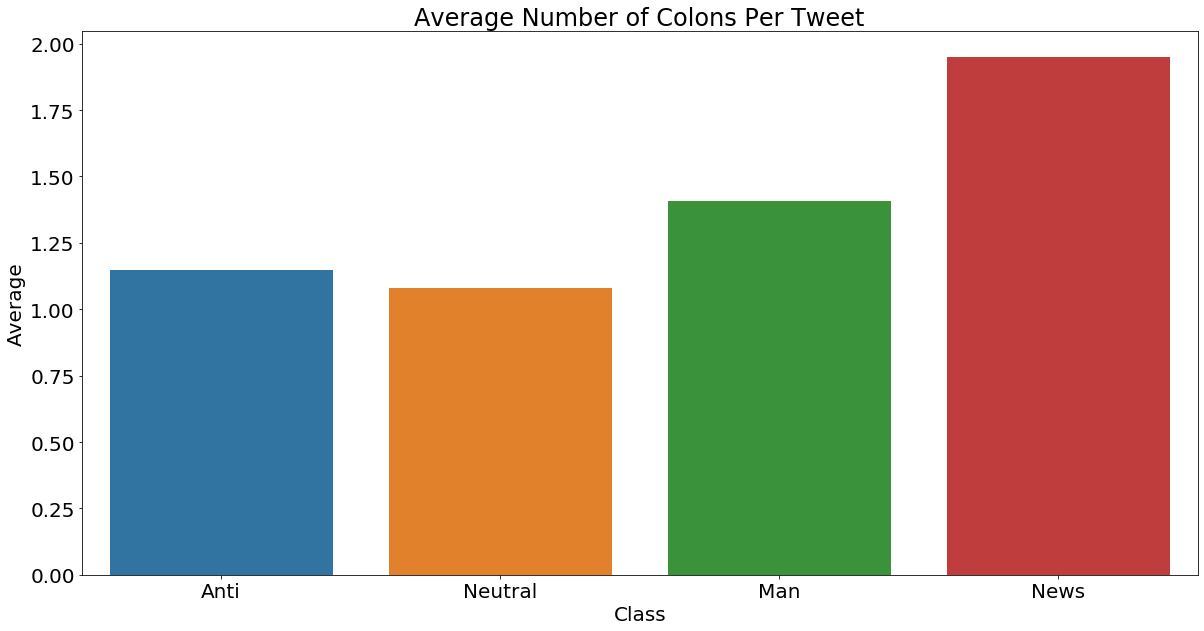

In [14]:
element_count_plot('colon_count',':','Colon')

Probably a colon right before a source link

#### Semi Colon

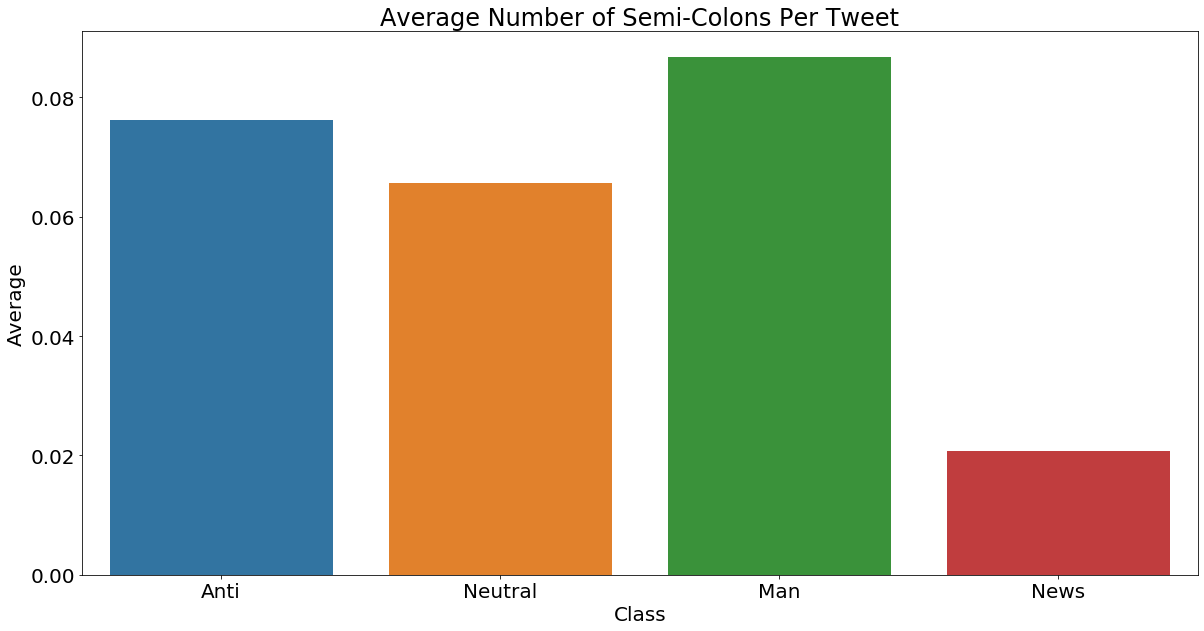

In [15]:
element_count_plot('semicolon_count',';','Semi-Colon')

Another way to differentiate the "News" class

### Word Associations

I figured in my thinking about this problem that certain classes would be more associated with certain concepts and groups of words. 

I found a website that outputs a list of words that are associated with an input word or term

You can find the website [here](https://relatedwords.org/)

In [5]:
# Loading in word lists
republican_party_words = load_republican_party_words()
democratic_party_words = load_democratic_party_words()
climate_change_words = load_climate_change_words()
news_words = load_news_words()

#### Republican Party

My first inclination was to try to get political terminology associated with each class. I started with the input: "Republican Party"

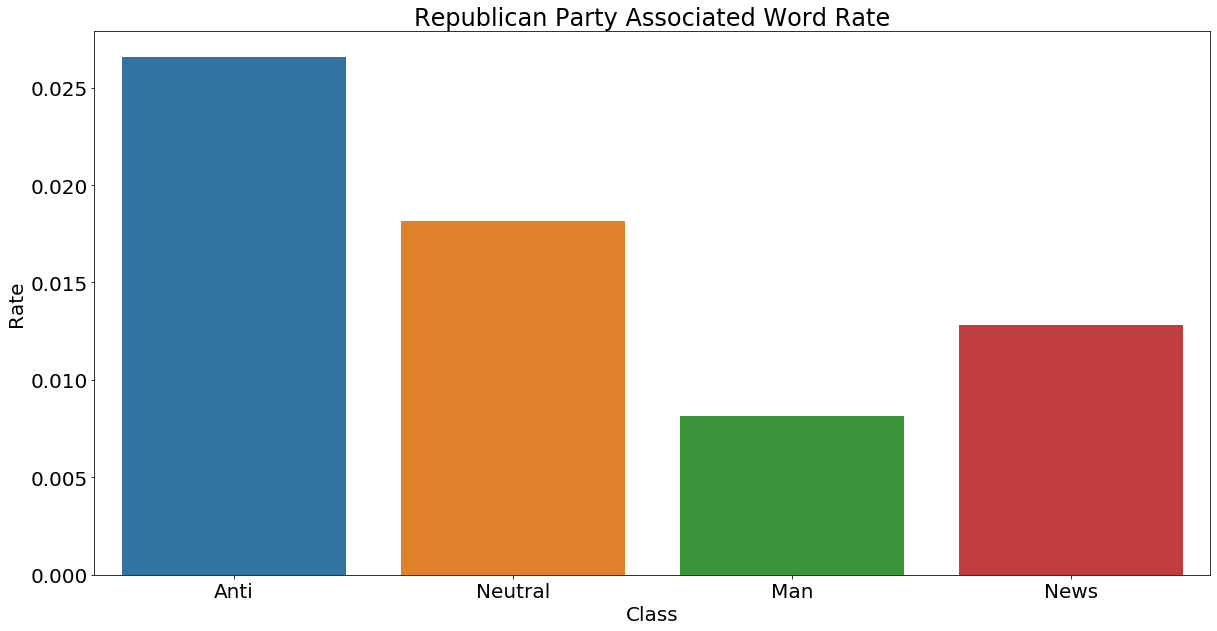

In [6]:
word_associations_plot(republican_party_words, 'Republican Party')

The graph above was not surprising. The association that I lean towards is the 'Anti' class with extreme conservatism on the republican side.

#### Democratic Party

With good first results, I moved onto inputting "Democratic Party" in hopes that the graph would show a strength in a different class

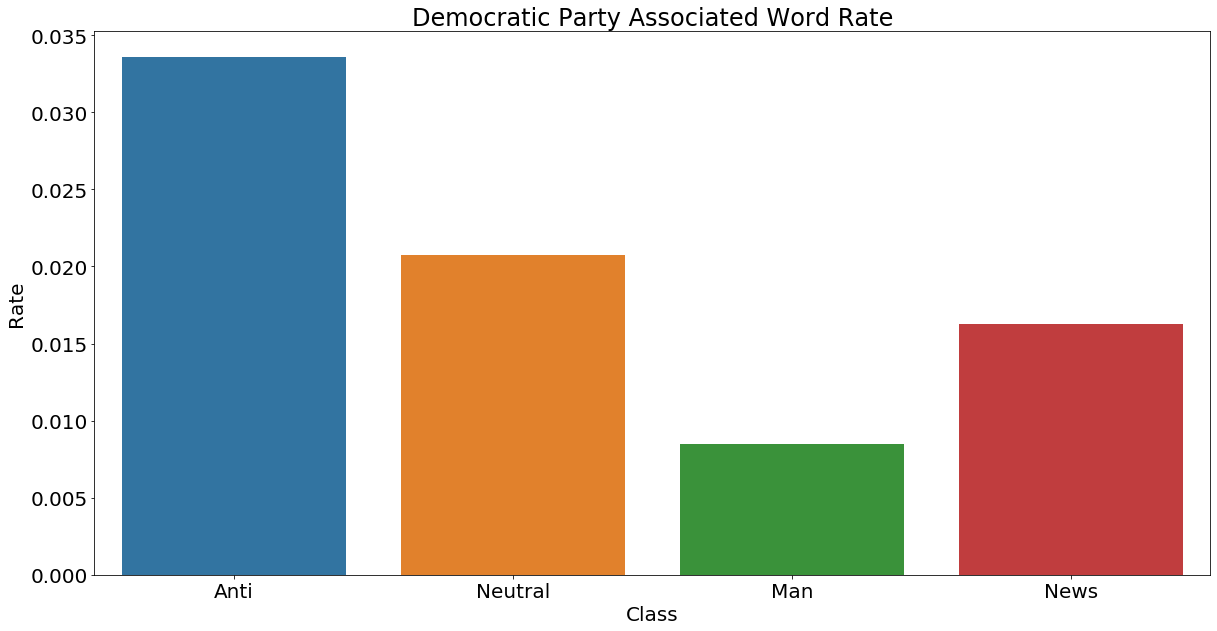

In [7]:
word_associations_plot(democratic_party_words, 'Democratic Party')

It was interesting to see this result. What I took away from this was that "Anti Man-Made" tweets are simply a bit more political in nature than the rest of the classes

#### Climate Change

It was a no brainer to try inputting "Climate Change." My hope with this was to uncover classes which were more likely to include more words about climate change related subjects than others

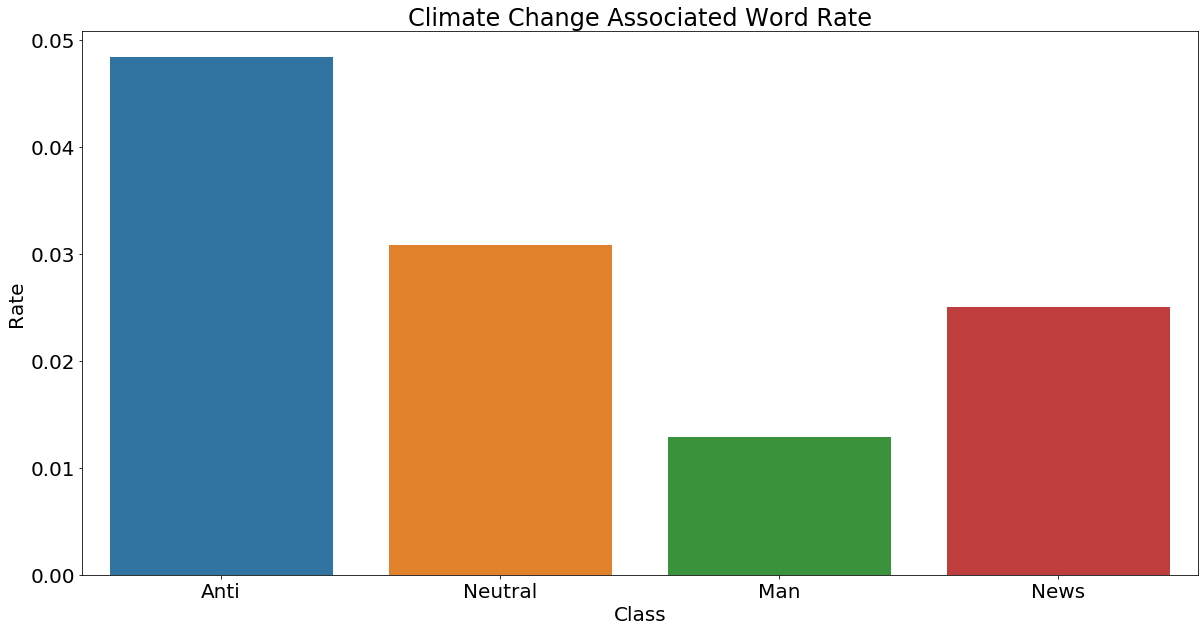

In [9]:
word_associations_plot(climate_change_words, 'Climate Change')

I was surprised by the findings. The "Anti Man-Made" class seemed to be the majority in every word-association thusfar

#### News

In an attempt to isolate the "News" class, I inputted "News." 

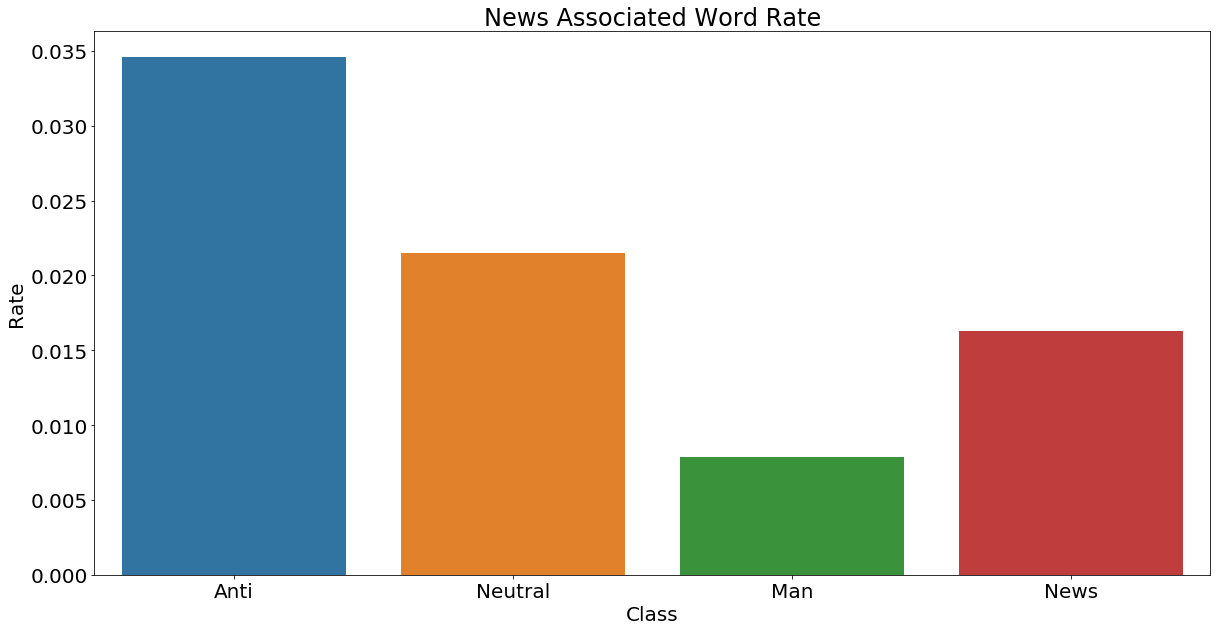

In [10]:
word_associations_plot(news_words, 'News')

This outputed a slightly higher percentage for the "News" class, but it still showed a majority in the "Anti Man-Made" class.

### Uppercase

From there I wanted to check whether full uppercase words were more present in one class over another. I wanted to see if emotional writing (which sometimes includes all capital letters) was more pervasive in one class over another.

In [11]:
data = pd.read_csv('./building_classifier/data/twitter_sentiment_data.csv')

In [12]:
# Tokenize and filter for letters
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
# Create uppercase present column
data['uppercase_present'] = data.message.apply(lambda x: tokenizer.tokenize(x))

# Checking if there are uppercase words per observation
data.uppercase_present = data.uppercase_present.apply(lambda x: check_uppercase(x))

Text(0, 0.5, 'Average')

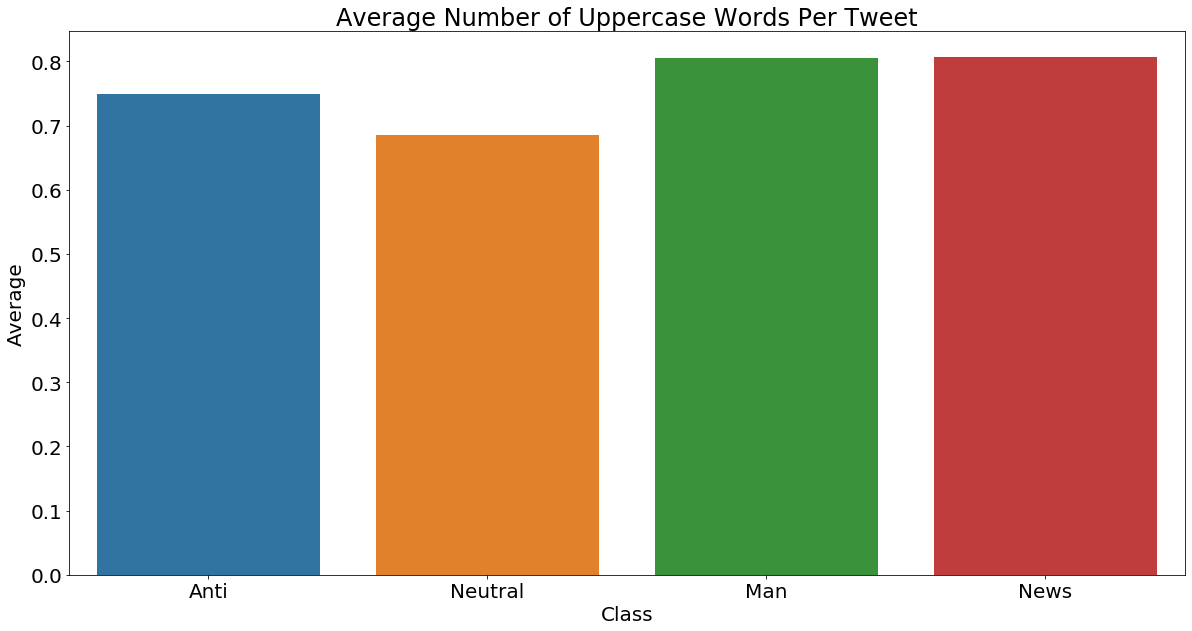

In [13]:
# Subsetting dataframe by class
anti = data[data.sentiment == -1]
neutral = data[data.sentiment == 0]
man = data[data.sentiment == 1]
news = data[data.sentiment == 2]

# Getting percentages of uppercase words per class
uppercase_count_perc = ((anti.uppercase_present.sum() / len(anti)),
                       (neutral.uppercase_present.sum() / len(neutral)),
                       (man.uppercase_present.sum() / len(man)),
                       (news.uppercase_present.sum() / len(news)))
                        
# Plotting bar graph                       
plt.figure(figsize=(20,10))
sns.barplot(class_labels, uppercase_count_perc)
plt.title('Average Number of Uppercase Words Per Tweet')
plt.xlabel('Class')
plt.ylabel('Average')

No real difference to be found

## Feature Engineering

[Back to Top](#Table-of-Contents)

In [14]:
data = pd.read_csv('./building_classifier/data/twitter_sentiment_data.csv')

### Simple Feature Engineering

I called this section simple feature engineering because I did not have to adapt of change the dataframe at all to produce these features. In total, there are 15. They are as follows:

 - textblob_polarity: textblob polarity score for message column value
 - textblob_subjectivity: textblob subjectivity score for message column value
 - tweet_length: length of message column value
 - hyperlink_present: binary for presence of hyperlink in message column value
 - retweet_present: binary for presence of retweet in message column value
 - mention_present: binary for presence of mention in message column value
 - mention_count: number of mentions present in message column value
 - hashtag_present: binary for presence of hashtag in message column value
 - hashtag_count: number of hashtags present in message column value
 - exclamation_point: binary for presence of exclamation point in message column value
 - question_mark: binary for presence of question mark in message column value
 - dollar_sign: binary for presence of dollar sign in message column value
 - percent_symbol: binary for presence of percent symbol in message column value
 - colon: binary for presence of colon in message column value
 - semi_colon: binary for presence of semi-colon in message column value

In [35]:
simple_custom_features(data)

,sentiment,message,tweetid,textblob_polarity,textblob_subjectivity,tweet_length,hyperlink_present,retweet_present,mention_present,mention_count,hashtag_present,hashtag_count,exclamation_point,question_mark,dollar_sign,percent_symbol,colon,semi_colon
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,0.250000,0.250000,137,0,0,1,1,0,0,0,0,0,0,0,0
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,0.285714,0.535714,146,1,1,1,2,1,1,0,0,0,0,1,0
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,0.750000,1.000000,117,1,0,1,1,1,2,1,0,0,0,1,0
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,0.300000,0.450000,143,1,1,1,1,0,0,0,0,0,0,1,0
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,0.100000,0.400000,139,0,1,1,1,0,0,0,0,0,0,1,1


### Complex Feature Engineering

Complex feature engineering just means that it took some dataframe adaptation in order to obtain the values for these columns

#### Uppercase Words

In [36]:
# Tokenizing words with a filter for letters
tokenize(data,r'[a-zA-Z]+')
# Creating new column indicating tweets with an uppercase word
data['uppercase_word'] = data.message.apply(lambda x: check_uppercase(x))

# Untokenizing data
untokenize(data)

,sentiment,message,tweetid,textblob_polarity,textblob_subjectivity,tweet_length,hyperlink_present,retweet_present,mention_present,mention_count,hashtag_present,hashtag_count,exclamation_point,question_mark,dollar_sign,percent_symbol,colon,semi_colon,uppercase_word
0,-1,tiniebeany climate change is an interesting hu...,792927353886371840,0.250000,0.250000,137,0,0,1,1,0,0,0,0,0,0,0,0,0
1,1,RT NatGeoChannel Watch BeforeTheFlood right he...,793124211518832641,0.285714,0.535714,146,1,1,1,2,1,1,0,0,0,0,1,0,1
2,1,Fabulous Leonardo DiCaprio s film on climate c...,793124402388832256,0.750000,1.000000,117,1,0,1,1,1,2,1,0,0,0,1,0,0
3,1,RT Mick Fanning Just watched this amazing docu...,793124635873275904,0.300000,0.450000,143,1,1,1,1,0,0,0,0,0,0,1,0,1
4,2,RT cnalive Pranita Biswasi a Lutheran from Odi...,793125156185137153,0.100000,0.400000,139,0,1,1,1,0,0,0,0,0,0,1,1,1


#### Word Associations

In [37]:
# Tokenizing words with a filter for letters
tokenize(data,r'[a-zA-Z]+')
# Lowercasing all words in message column
data.message = data.message.apply(lambda x: lowercase(x))

# New column indicating word count coinciding with republican party words
data['republican_party_words'] = data.message.apply(lambda x: word_association_features(x, load_republican_party_words()))
# New column indicating word count coinciding with democratic party words
data['democratic_party_words'] = data.message.apply(lambda x: word_association_features(x, load_democratic_party_words()))
# New column indicating word count coinciding with climate change words
data['climate_change_words'] = data.message.apply(lambda x: word_association_features(x, load_climate_change_words()))
# New column indicating word count coinciding with news words
data['news_words'] = data.message.apply(lambda x: word_association_features(x, load_news_words()))


# Untokenizing data
untokenize(data)

,sentiment,message,tweetid,textblob_polarity,textblob_subjectivity,tweet_length,hyperlink_present,retweet_present,mention_present,mention_count,hashtag_present,hashtag_count,exclamation_point,question_mark,dollar_sign,percent_symbol,colon,semi_colon,uppercase_word,republican_party_words,democratic_party_words,climate_change_words,news_words
0,-1,tiniebeany climate change is an interesting hu...,792927353886371840,0.250000,0.250000,137,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,6,8
1,1,rt natgeochannel watch beforetheflood right he...,793124211518832641,0.285714,0.535714,146,1,1,1,2,1,1,0,0,0,0,1,0,1,0,0,3,3
2,1,fabulous leonardo dicaprio s film on climate c...,793124402388832256,0.750000,1.000000,117,1,0,1,1,1,2,1,0,0,0,1,0,0,0,0,2,1
3,1,rt mick fanning just watched this amazing docu...,793124635873275904,0.300000,0.450000,143,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,4,3
4,2,rt cnalive pranita biswasi a lutheran from odi...,793125156185137153,0.100000,0.400000,139,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,3,6


## Basline KNN Model

[Back to Top](#Table-of-Contents)

For my baseline model, I chose to run a KNN model because of its quick run time and proven performance in classification modeling.

In [135]:
data = pd.read_csv('./building_classifier/data/prepared_twitter_sentiment_data.csv', index_col=0)

# Drop 31 missing values from messages column
data.dropna(inplace=True)

### TFIDF Vectorization

A unigram TF-IDF vectorizer was used in order to simplify the results for the baseline model

In [136]:
# Get X and y for Vectorization
X = data.message
y = data.sentiment

# Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# Create TFIDF Vectorizer including unigrams through trigrams
tfidf = TfidfVectorizer(ngram_range= (1,1))
# Fitting and transforming X_train with TFIDF Vectorizer
tfidf_train = tfidf.fit_transform(X_train)
# Transforming X_test with TFIDF Vectorizer
tfidf_test = tfidf.transform(X_test)

### KNN Model

In [137]:
# Creating instance of KNeighborsClassifier
knn = KNeighborsClassifier()
# Fitting training data to KNeighborsClassifier
base_knn_model = knn.fit(tfidf_train, y_train)
# Predicting on test data with KNeighborsClassifier
base_preds = base_knn_model.predict(tfidf_test)

### Evaluation

In [138]:
# Cross val score
print((cross_val_score(knn, tfidf_train, y_train, cv = 10, scoring='f1_micro')).mean())

0.6031765191054119


In [139]:
# Classification Report for KNeighborsClassifier model
print(classification_report(y_test, base_preds))

              precision    recall  f1-score   support

          -1       0.48      0.40      0.44       823
           0       0.40      0.49      0.44      1549
           1       0.71      0.70      0.70      4526
           2       0.63      0.58      0.60      1885

    accuracy                           0.61      8783
   macro avg       0.55      0.54      0.55      8783
weighted avg       0.61      0.61      0.61      8783



Baseline KNN Confusion Matrix
[[ 332  210  214   67]
 [ 136  756  526  131]
 [ 172  751 3162  441]
 [  52  183  566 1084]]
Baseline KNN Confusion Matrix (Normalized)
[[0.40340219 0.25516403 0.2600243  0.08140948]
 [0.08779858 0.48805681 0.33957392 0.08457069]
 [0.03800265 0.16593018 0.69863014 0.09743703]
 [0.02758621 0.09708223 0.30026525 0.57506631]]


<Figure size 1440x720 with 0 Axes>

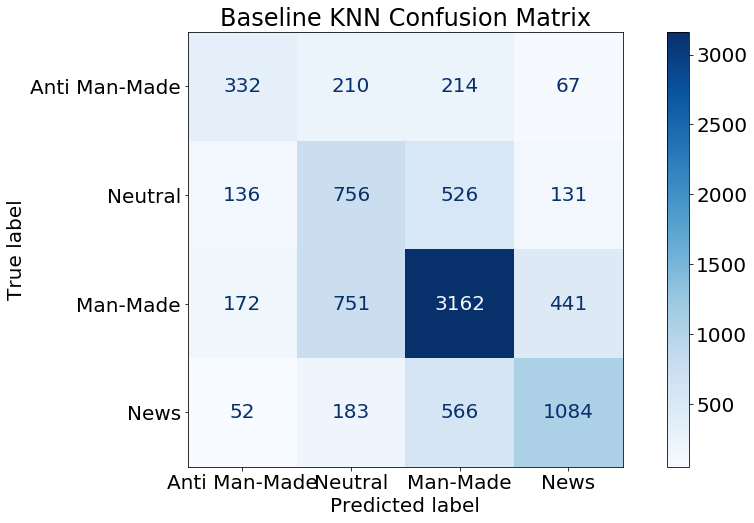

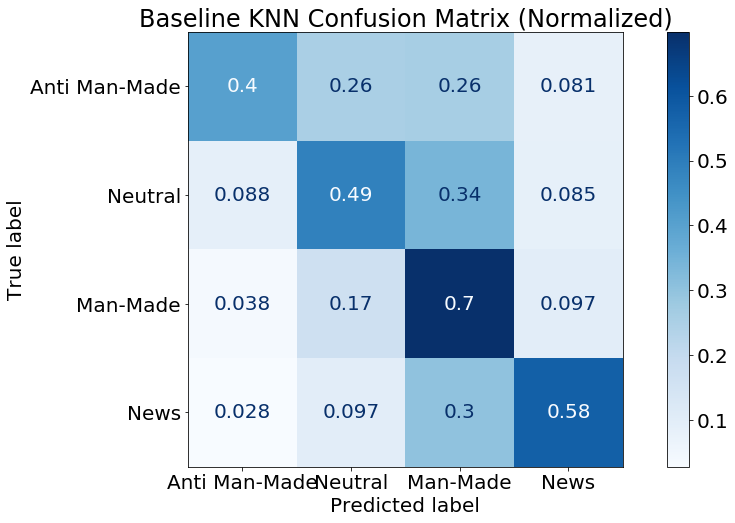

In [140]:
# Setting class names for confusion matrix
class_names = ['Anti Man-Made', 'Neutral', 'Man-Made', 'News']

# Plotting confusion matrixes
plt.figure(figsize=(20,10))
titles_options = [("Baseline KNN Confusion Matrix", None),
                  ("Baseline KNN Confusion Matrix (Normalized)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, tfidf_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
  

plt.show()

The baseline model performed quite well. The model got an aggregate f1 score of 0.603. The ultimate concern is with the 'Anti' and 'Man' classes, however. And, with that in mind, the model performed much better with the 'Man' class than with the 'Anti' class. That is as expected, though. Moving into the modeling process, the 'Anti' f1 score of 0.44, which surely needs to be improved.

## Choosing Best Model

[Back to Top](#Table-of-Contents)

### TFIDF Logistic Regression

For this section, I chose to only include the model that performed the best from my modeling with TFIDF Vectorizer. If you would like to check out the rest of models, you can check out the notebook [here](./archive/modeling)

#### Data Prep

In [75]:
data = pd.read_csv('./building_classifier/data/prepared_twitter_sentiment_data.csv', index_col=0)

# Drop 31 rows with missing message column
data.dropna(inplace=True)

In [76]:
# Separating X and y
X = data.drop(columns = 'sentiment')
y = data.sentiment

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=1)

It turned out, after including bigrams and trigrams, that the model performed the best with just unigrams

In [77]:
# Instantiate vectorizer
tfidf = TfidfVectorizer(ngram_range= (1,1))
# Fit to training data
tfidf_train = tfidf.fit_transform(X_train.message)
# Transform test data
tfidf_test = tfidf.transform(X_test.message)

# Convert vectors to dataframe
tfidf_train_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_train, columns=tfidf.get_feature_names())
tfidf_test_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_test, columns=tfidf.get_feature_names())

#### Fitting and Predicting

In [78]:
# Instantiate Classifier
lr_tfidf = LogisticRegression()
# Fit to training data
lr_tfidf.fit(tfidf_train_df, y_train)
# Predict on testing data
lr_tfidf_preds = lr_tfidf.predict(tfidf_test_df)

#### Model Evaluation

In [79]:
# Cross val score
print((cross_val_score(lr_tfidf, tfidf_train_df, y_train, cv = 10, scoring='f1_micro')).mean())

0.7055992969815337


In [80]:
# Evaluating with classification report
print(classification_report(y_test, lr_tfidf_preds))

              precision    recall  f1-score   support

          -1       0.73      0.41      0.52       823
           0       0.63      0.43      0.51      1549
           1       0.71      0.87      0.78      4526
           2       0.73      0.66      0.69      1885

    accuracy                           0.70      8783
   macro avg       0.70      0.59      0.63      8783
weighted avg       0.70      0.70      0.69      8783



TFIDF Logistic Regression Confusion Matrix
[[ 334  127  317   45]
 [  51  659  732  107]
 [  55  217 3954  300]
 [  15   47  580 1243]]
TFIDF Logistic Regression Confusion Matrix (Normalized)
[[0.40583232 0.15431349 0.38517618 0.05467801]
 [0.03292447 0.42543577 0.47256294 0.06907682]
 [0.01215201 0.04794521 0.87361909 0.06628369]
 [0.00795756 0.02493369 0.30769231 0.65941645]]


<Figure size 1440x720 with 0 Axes>

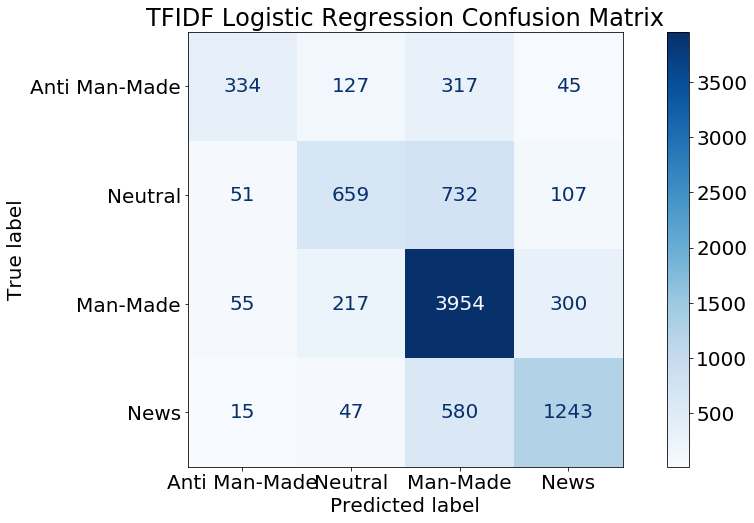

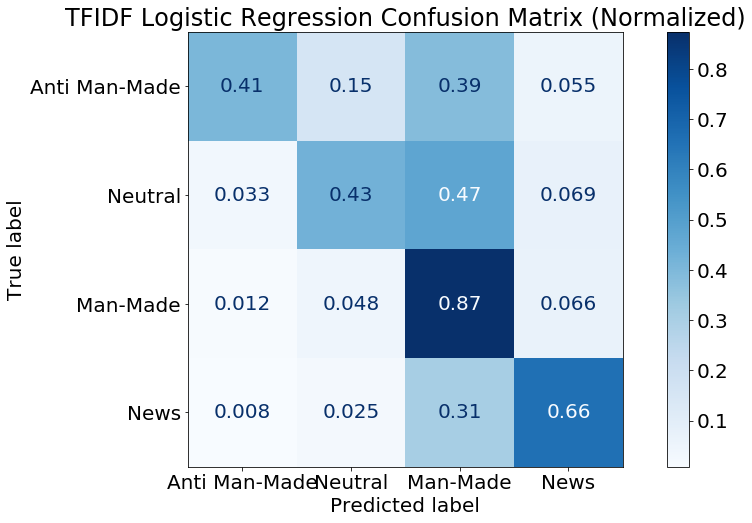

In [81]:
# Setting class names for confusion matrix
class_names = ['Anti Man-Made', 'Neutral', 'Man-Made', 'News']

# Plot confusion matrix
plt.figure(figsize=(20,10))
titles_options = [("TFIDF Logistic Regression Confusion Matrix", None),
                  ("TFIDF Logistic Regression Confusion Matrix (Normalized)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr_tfidf, tfidf_test_df, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

The model above greatly outperformed the baseline model with an aggregate f1 score of 0.706. Our target classes, 'Anti' and 'Man', were both better for this model in terms of differentiation. The f1 score of 'Anti' is 0.52 and 'Man' is 0.78. The 'Anti' class still needs to be improved, but this model does a pretty good job. 

### Doc2Vec + Engineered Features Random Forest

For this section, I chose to only include the model that performed the best from my modeling with Doc2Vec. If you would like to check out the rest of models, you can check out the notebook [here](./archive/modeling)

#### Data Prep

In [82]:
data = pd.read_csv('./building_classifier/data/prepared_twitter_sentiment_data.csv', index_col=0)

# Drop 31 rows with missing values in message column
data.dropna(inplace=True)

In [83]:
# Reassigning target variable names to exclude -1
data.sentiment = data.sentiment.apply(lambda x: 'anti' if x == -1 else x)
data.sentiment = data.sentiment.apply(lambda x: 'neutral' if x == 0 else x)
data.sentiment = data.sentiment.apply(lambda x: 'man' if x == 1 else x)
data.sentiment = data.sentiment.apply(lambda x: 'news' if x == 2 else x)

# Performing train test split including target variable
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Separating target variables from train and test
y_train_doc = train.sentiment
y_test_doc = test.sentiment

After trying many different values for the vector size parameter in Doc2Vec, the one that performed the based for the modeling process was 10, as seen below

In [84]:
# Tokenizing and tagging each observation message column
train_docs = train.apply(lambda x: TaggedDocument(words=x.message.split(), tags=[x.sentiment]), axis=1)

# Tokenizing train and test data
train_data = [tweet.split() for tweet in train['message']]
test_data = [tweet.split() for tweet in test['message']]

# training Doc2Vec
model = Doc2Vec(vector_size=10, 
                alpha=0.025, 
                min_count=5,
                epochs=100)

model.build_vocab(train_docs)
model.train(train_docs, 
            total_examples=model.corpus_count, 
            epochs=model.epochs)

In [85]:
# infer in multiple steps to get a stable representation 
train_vecs = [model.infer_vector(words, epochs=100) \
              for words in train_data]
test_vecs = [model.infer_vector(words, epochs=100) \
             for words in test_data]

In [86]:
# convert both sets to dataframe
doc_train_df = pd.DataFrame(train_vecs, columns=[
    f'docvec_{i}' for i in range(1,11)
])

doc_test_df = pd.DataFrame(test_vecs, columns=[
    f'docvec_{i}' for i in range(1,11)
])

In [87]:
# Extracting just features from dataframe
train_features = train.drop(columns=['sentiment','message'])
test_features = test.drop(columns=['sentiment','message'])

# Reset index to match doc2vec dataframe
train_features.reset_index(drop=True, inplace=True)
test_features.reset_index(drop=True, inplace=True)

# Combining Doc2Vec with custom features
doc_train_featured = doc_train_df.join(train_features, how='outer')
doc_test_featured = doc_test_df.join(test_features, how='outer')

#### Fitting and Predicting

In [88]:
# Instantiate Classifier
rf_doc_featured = RandomForestClassifier(class_weight='balanced')

# Fit to training data
rf_doc_featured.fit(doc_train_featured, y_train_doc)

# Predict on testing data
rf_doc_featured_preds = rf_doc_featured.predict(doc_test_featured)

#### Evaluation

In [89]:
# Cross val score
print((cross_val_score(rf_doc_featured, doc_train_featured, y_train_doc, cv = 10, scoring='f1_micro')).mean())

0.7492384615035464


In [90]:
# Print out classification report
print(classification_report(y_test_doc, rf_doc_featured_preds))

              precision    recall  f1-score   support

        anti       0.63      0.39      0.48       785
         man       0.68      0.87      0.76      4529
     neutral       0.59      0.37      0.46      1562
        news       0.76      0.62      0.69      1907

    accuracy                           0.68      8783
   macro avg       0.67      0.56      0.60      8783
weighted avg       0.68      0.68      0.67      8783



Doc2Vec (with Features) Random Forest Confusion Matrix
[[ 304  346  108   27]
 [  82 3926  252  269]
 [  75  829  579   79]
 [  22  656   39 1190]]
Doc2Vec (with Features) Random Forest Confusion Matrix (Normalized)
[[0.38726115 0.44076433 0.13757962 0.0343949 ]
 [0.01810554 0.86685803 0.05564142 0.05939501]
 [0.04801536 0.53072983 0.37067862 0.05057618]
 [0.01153644 0.3439958  0.02045097 0.62401678]]


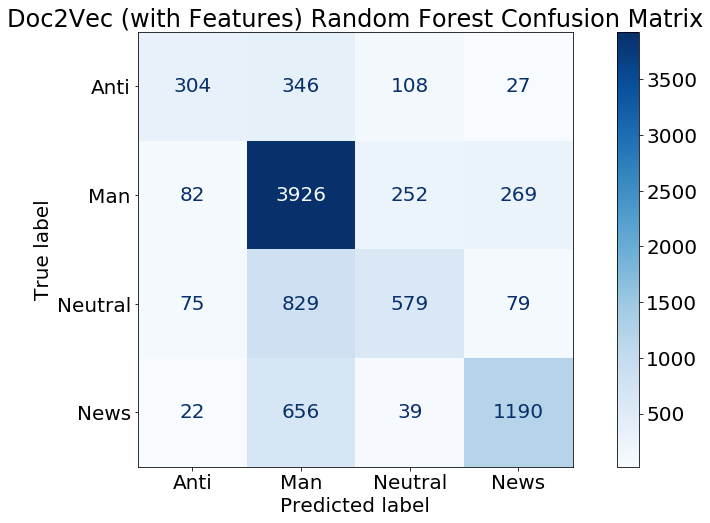

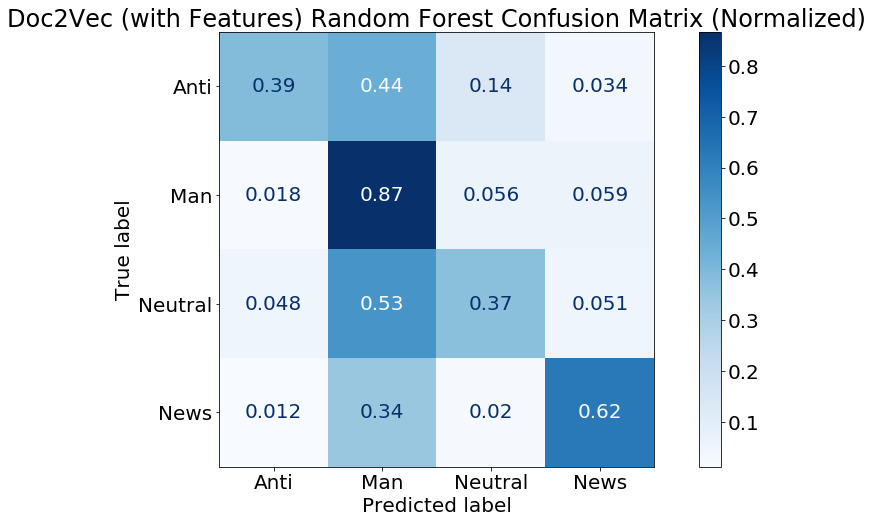

In [91]:
# Plot confusion matrices
titles_options = [("Doc2Vec (with Features) Random Forest Confusion Matrix", None),
                  ("Doc2Vec (with Features) Random Forest Confusion Matrix (Normalized)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf_doc_featured, doc_test_featured, y_test_doc,
                                 display_labels=['Anti','Man','Neutral','News'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

The model above outperformed the TF-IDF logistic regression model, with an aggregate f1 score of 0.749. Unfortunately, the model performed poorly when differentiated the 'Anti' class, getting an f1 score of 0.48, indicating that the model would differentiate the 'Anti' class correctly less than half of the time.

## Parameter Tuning Best Model

[Back to Top](#Table-of-Contents)

For my final model, I chose the logistic regression model using TFIDF Vectorization. This model was chosen over the Doc2Vec random forest model because of its outperformance in the 'Anti' class, despite its lower aggregate f1 score.

In the model iterations below, RandomSearchCV will be used three separate times, each time narrowing down further onto the best parameters for the model.

### First Iteration

In [92]:
# Setting searching parameters for RandomSearch
param_grid = {
    'penalty': ['l1','l2'],
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs','liblinear']
}

In [93]:
# Instantiate Classifier
lr_final = LogisticRegression(random_state=42)
# Instantiate GridSearch
rand_lr_final = RandomizedSearchCV(lr_final, 
                                   param_grid, 
                                   n_jobs=-1,
                                   verbose=2,
                                   scoring='f1_micro')

In [94]:
# Fit grid_lr_final to training data
rand_lr_final.fit(tfidf_train_df, y_train)
# Predict on testing data
rand_lr_final_preds = rand_lr_final.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, rand_lr_final_preds))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

          -1       0.69      0.48      0.57       823
           0       0.58      0.46      0.52      1549
           1       0.74      0.84      0.78      4526
           2       0.72      0.69      0.70      1885

    accuracy                           0.71      8783
   macro avg       0.68      0.62      0.64      8783
weighted avg       0.70      0.71      0.70      8783



In [95]:
f1_score(y_test, rand_lr_final_preds, average='micro')

0.7071615621086189

In [96]:
rand_lr_final.best_params_

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 4.281332398719396}

### Second Iteration

In [106]:
param_grid_2 = {
    'C': [2, 3, 4, 5, 6],
    'max_iter': [200, 300, 400, 500, 600]
}

In [107]:
# Instantiate Classifier
lr_final_2 = LogisticRegression(solver = 'lbfgs', penalty = 'l2', random_state=42)
# Instantiate GridSearch
rand_lr_final_2 = RandomizedSearchCV(lr_final_2, 
                                   param_grid_2, 
                                   n_jobs=-1,
                                   verbose=2,
                                   scoring='f1_micro',
                                   cv = 5)

In [108]:
# Fit grid_lr_final to training data
rand_lr_final_2.fit(tfidf_train_df, y_train)
# Predict on testing data
rand_lr_final_preds_2 = rand_lr_final_2.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, rand_lr_final_preds_2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

          -1       0.69      0.48      0.57       823
           0       0.59      0.46      0.52      1549
           1       0.73      0.84      0.79      4526
           2       0.72      0.69      0.71      1885

    accuracy                           0.71      8783
   macro avg       0.68      0.62      0.64      8783
weighted avg       0.70      0.71      0.70      8783



In [109]:
f1_score(y_test, rand_lr_final_preds_2, average='micro')

0.709552544688603

In [110]:
rand_lr_final_2.best_params_

{'max_iter': 200, 'C': 4}

### Third Iteration

In [113]:
param_grid_3 = {
    'max_iter': [180,190,200,210,220],
    'C': [3.7,3.8,3.9,4,4.1,4.2,4.3]
}

In [117]:
# Instantiate Classifier
lr_final_3 = LogisticRegression(solver='lbfgs',
                                penalty = 'l2', 
                                random_state=42)
# Instantiate GridSearch
rand_lr_final_3 = RandomizedSearchCV(lr_final_3, 
                                   param_grid_3, 
                                   n_jobs=-1,
                                   verbose=2,
                                   scoring='f1_micro',
                                   cv = 5)

In [118]:
# Fit grid_lr_final to training data
rand_lr_final_3.fit(tfidf_train_df, y_train)
# Predict on testing data
rand_lr_final_preds_3 = rand_lr_final_3.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, rand_lr_final_preds_3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

          -1       0.69      0.48      0.57       823
           0       0.59      0.46      0.52      1549
           1       0.74      0.84      0.79      4526
           2       0.72      0.69      0.71      1885

    accuracy                           0.71      8783
   macro avg       0.68      0.62      0.64      8783
weighted avg       0.70      0.71      0.70      8783



In [119]:
f1_score(y_test, rand_lr_final_preds_3, average='micro')

0.7098941136286007

In [120]:
rand_lr_final_3.best_estimator_

LogisticRegression(C=4.3, max_iter=180, random_state=42)

Hyperparameter Tuned TFIDF Logistic Regression Confusion Matrix
[[ 395  132  255   41]
 [  77  719  634  119]
 [  77  294 3820  335]
 [  22   79  483 1301]]
Hyperparameter Tuned TFIDF Logistic Regression Confusion Matrix (Normalized)
[[0.4799514  0.16038882 0.30984204 0.04981774]
 [0.04970949 0.46417043 0.40929632 0.07682376]
 [0.01701281 0.06495802 0.84401237 0.07401679]
 [0.01167109 0.04190981 0.25623342 0.69018568]]


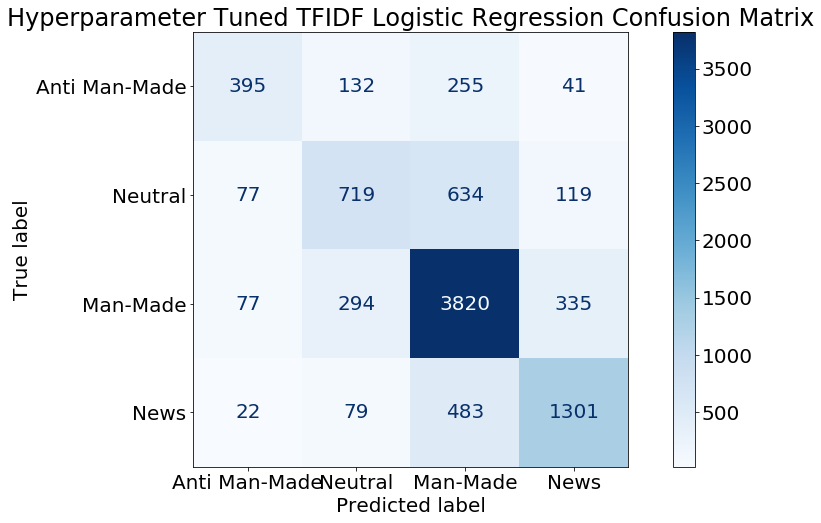

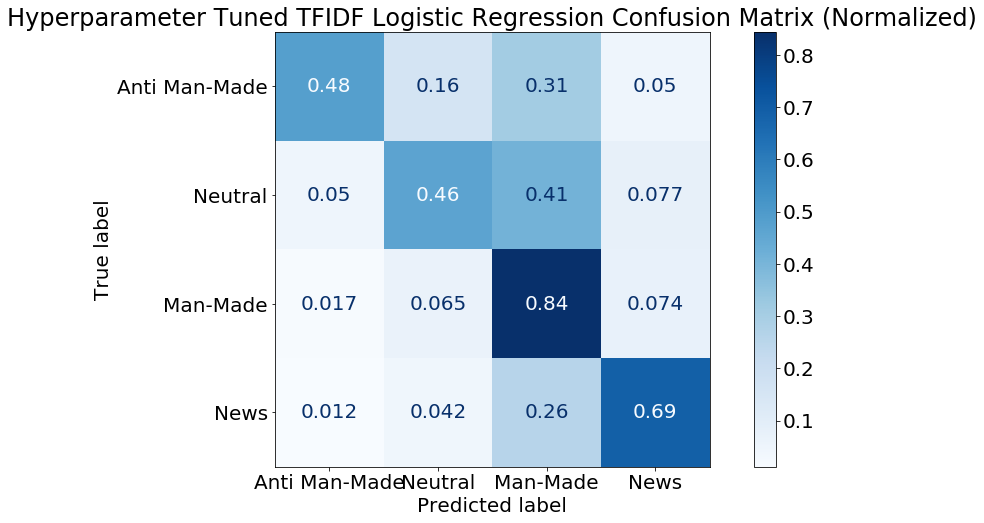

In [121]:
# Plot non-normalized confusion matrix
titles_options = [("Hyperparameter Tuned TFIDF Logistic Regression Confusion Matrix", None),
                  ("Hyperparameter Tuned TFIDF Logistic Regression Confusion Matrix (Normalized)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rand_lr_final_3, tfidf_test_df, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.grid(False)
plt.show()

## Building a Classifier Conclusion

[Back to Top](#Table-of-Contents)

As seen above, the best performing model was a logistic regression using TFIDF Vectorization. Although the model still does not do a great job identifying the 'Anti' class, the final model is better than the baseline model by a margin of 0.13. With the model's differentiation ability, it will do well enough to deploy in geographic and time series analysis. 

# Applying the Classifier

[Back to Top](#Table-of-Contents)

This section of the notebook applies the classifier to tweets scraped using both twint and tweepy. For analysis of the 'Anti' vs the 'Man' class, the scores from this section represent an average of only 'Anti' and 'Man' with -1 and 1 as their respective values. This section allows for the EDF to see what states will be most likely to donate and which months people are more likely to donate. 

## Applying Classifier Imports

In [20]:
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import folium

plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.prop_cycle'].by_key()['color'] = ['blue','orange','pink']
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'bold'

## Time Series Analysis

[Back to Top](#Table-of-Contents)

In [21]:
# csv for time series data
daily = pd.read_csv('./applying_classifier/time_series/data/time_series_daily_data.csv',index_col=0)
# Setting inded to datetime
daily.index = pd.to_datetime(daily.index)
# Checking dataframe
daily.head()

,sentiment
date,
2009-12-31,22.39
2010-01-01,33.56
2010-01-02,37.18
2010-01-03,22.55
2010-01-04,31.96


### Checking for Trends in Mean and Standard Deviation

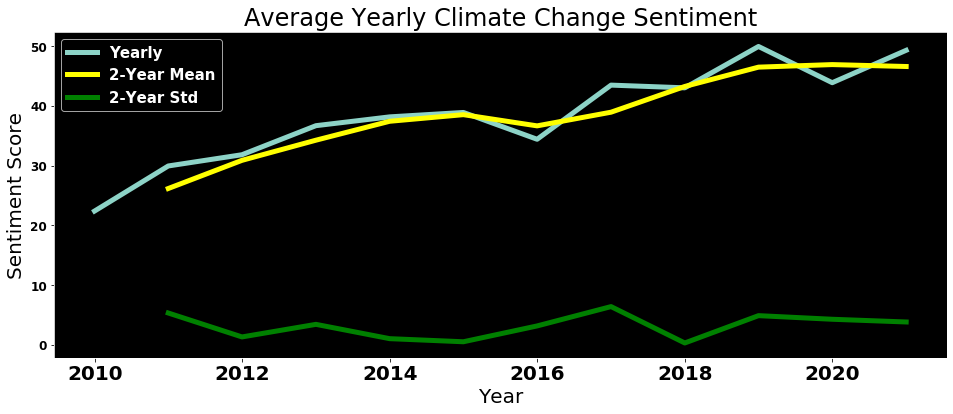

In [22]:
# Resampling data by year
yearly_mean = daily.resample('Y').mean()
# Creating rolling mean with window of 2 years
year_roll_mean_2 = yearly_mean.rolling(window=2, center=False).mean()
# Creating rolling standard deviation with window of 2 years
year_roll_std_2 = yearly_mean.rolling(window=2, center=False).std()

# Plotting yearly data
plt.figure(figsize=(16,6))
plt.plot(yearly_mean, label='Yearly', linewidth=5)
plt.plot(year_roll_mean_2, label='2-Year Mean', linewidth=5,color='yellow')
plt.plot(year_roll_std_2, label='2-Year Std', linewidth=5,color='green')
plt.title("Average Yearly Climate Change Sentiment", color = 'black')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.legend(loc='upper left',fontsize=15)

### Checking for Seasonality

As mentioned in the overview, it will be helpful for the EDF to know, by month, when to deploy advertising and promotions in an effort to receive donations. Below is a breakdown of that idea, which includes the months where donations should, according to the assumption in the overview, represent the highest and lowest donations of the year. 

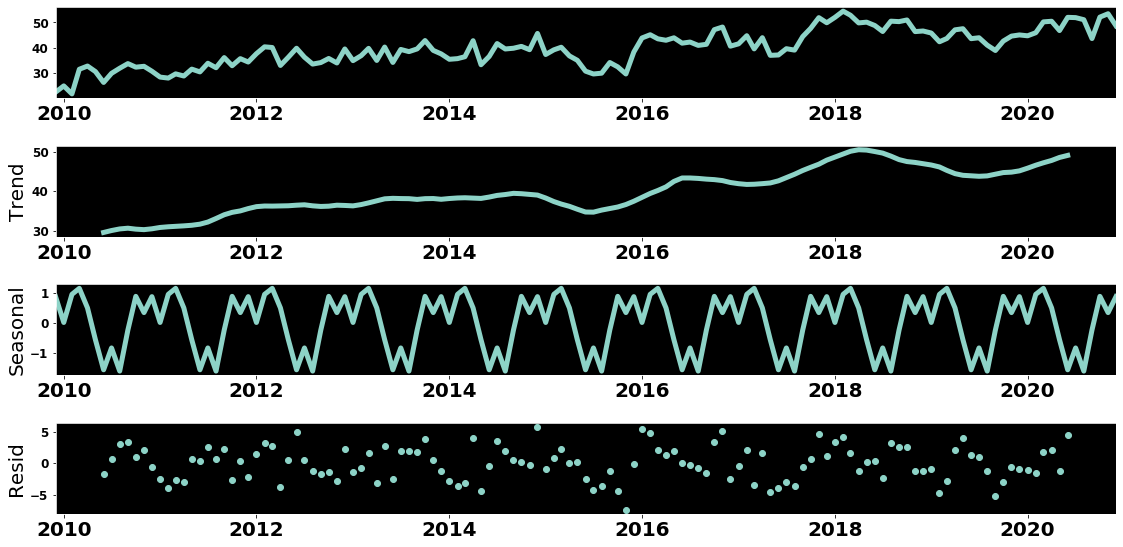

In [23]:
# Resampling data by month
monthly_mean = daily.resample('MS').mean()
# Creating seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
# Plotting decomposition
fig = decomposition.plot()
plt.show()

It is clear from the decomposition graph above that climate change sentiment does possess a seasonal element. Therefore, it makes sense to now see what months of the year climate change sentiment is at its highest and what months of the year its at its lowest. 

In [24]:
# Creating dataframe out of seasonal data
seasonal_data = pd.DataFrame(decomposition.seasonal)
# Setting index to datetime
seasonal_data.index = pd.to_datetime(seasonal_data.index)
# Getting months where sentiment is above average
above_average_sentiment = list(set(seasonal_data[seasonal_data.seasonal > 0].index.month))
# Getting months where sentiment is below average
below_average_sentiment = list(set(seasonal_data[seasonal_data.seasonal < 0].index.month))
# Checking for highest sentiment month
highest_value = seasonal_data[seasonal_data.seasonal > 0].max()
highest_sentiment_month = seasonal_data[seasonal_data.seasonal == highest_value[0]].index[0].month
# Checking for lowest sentiment month
lowest_value = seasonal_data[seasonal_data.seasonal < 0].min()
lowest_sentiment_month = seasonal_data[seasonal_data.seasonal == lowest_value[0]].index[0].month

In [25]:
# Printing sentiment above and below average
print('Climate change sentiment above average months: {}'.format(above_average_sentiment))
print('Climate change sentiment below average months: {}'.format(below_average_sentiment))
print('\n')
# Printing highest and lowest sentiment
print('Highest climate change sentiment month: {}'.format(highest_sentiment_month))
print('Lowest climate change sentiment month: {}'.format(lowest_sentiment_month))

Climate change sentiment above average months: [1, 2, 3, 4, 10, 11, 12]
Climate change sentiment below average months: [5, 6, 7, 8, 9]


Highest climate change sentiment month: 3
Lowest climate change sentiment month: 8


### Forecasting Climate Change Sentiment

In order to find out the donations the EDF can expect to receive in the future, it is essential to forecast climate change sentiment into the future. In order to do this, a SARIMA model will be used because of the seasonality element that was found above. The forecast will be accomplished using the SARIMA model that is fit to the climate change monthly mean data. 

#### SARIMA Model

In [26]:
# Naming range 0-2 as p, d, and q
p = d = q = range(0, 2)
# Getting cartesian product
pdq = list(itertools.product(p, d, q))
# Setting variable equal to pdq plus 12
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [27]:
# Finding order and seasonal_order with lowest AIC
all_params = []
all_param_seasonal = []
all_test_results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        test_mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        
        test_results = test_mod.fit()
        all_params.append(param)
        all_param_seasonal.append(param_seasonal)
        all_test_results.append(test_results.aic)
        
best_test_results = min(all_test_results)
best_test_results_index = all_test_results.index(best_test_results)

# Printing order and seasonal_order params with best results
print('Order: {}'.format(all_params[best_test_results_index]))
print('Seasonal Order: {}'.format(all_param_seasonal[best_test_results_index]))

Order: (0, 1, 1)
Seasonal Order: (0, 1, 1, 12)


In [28]:
# Building and fitting model
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=(0,1,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fitting model
results = mod.fit()

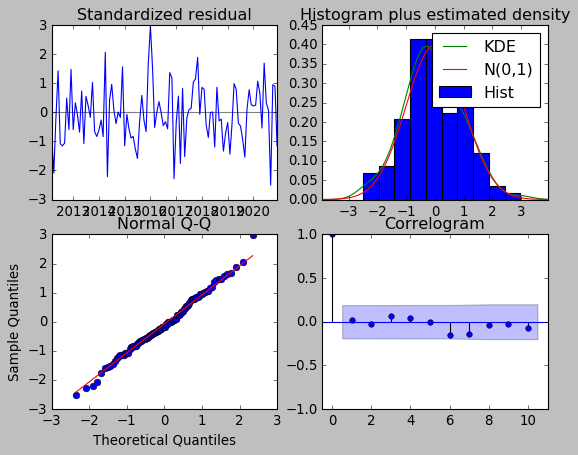

In [29]:
# Plotting results diagnostics
plt.style.use('classic')
results.plot_diagnostics()
plt.show()

From the noraml Q-Q plot, we can see that we have find a rather straight line, which tells us that we have no systematic departure from normality. Additionally, the Correlogram tells us that there is no autocorrelation in the residuals, marking them as white noise. 

#### Checking Forecasting Accuracy

To test the accuracy of the SARIMA model, predictions will be made on past data below. The predictions represent the model's forecasts, which we will be able to judge the accuracy of given we are forecasted on data we possess.

In [30]:
# Creating predictions for past data
pred = results.get_prediction(start = pd.to_datetime('2015-01-01'),
                              dynamic = False)
# Creating variable for pred confidence interval
pred_ci = pred.conf_int()

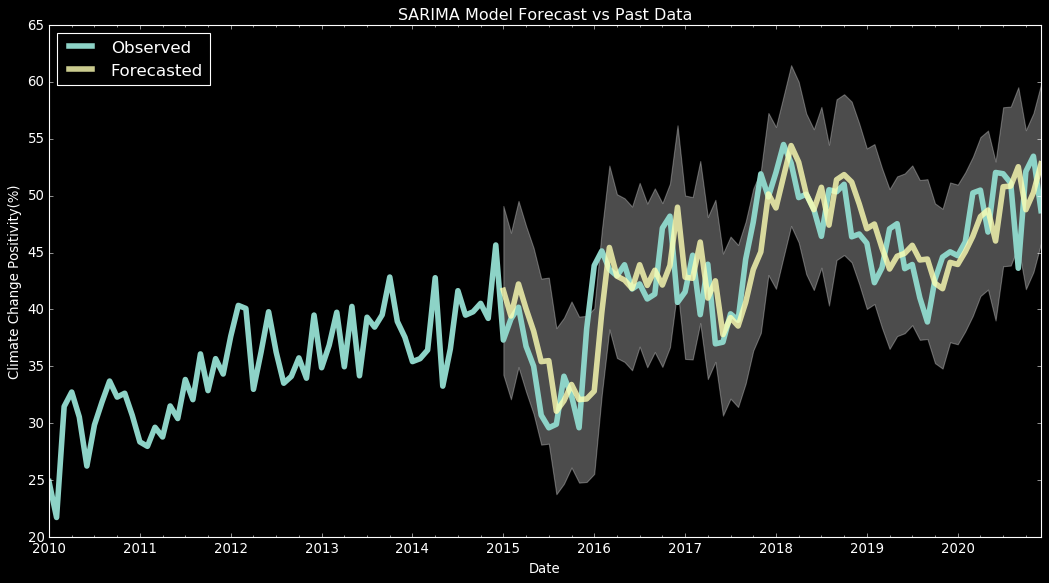

In [32]:
# Plotting predictions
plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['lines.linewidth'] = 5
plt.style.use('dark_background')
ax = monthly_mean['2010':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.8)

# Plotting 95% confidence interval
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='white', alpha=.3)

# Setting graph specifications
ax.set_title('SARIMA Model Forecast vs Past Data')
ax.set_xlabel('Date')
ax.set_ylabel('Climate Change Positivity(%)')
plt.legend(loc='upper left',fontsize=15, labels=['Observed','Forecasted'])

In [33]:
# Created forecasted predictions list
y_forecasted = (pred.predicted_mean).to_list()
# Getting true values list
y_truth = monthly_mean['2015-01-01':]
y_truth = y_truth.sentiment.to_list()
# Calculating MSE
MSE = mean_squared_error(y_truth, y_forecasted)
print('The Mean Squared Error of our forecasts is {}'.format(round(MSE, 2)))
# Calculating RMSE
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(MSE), 2)))

The Mean Squared Error of our forecasts is 13.52
The Root Mean Squared Error of our forecasts is 3.68


#### Producing Forecasts

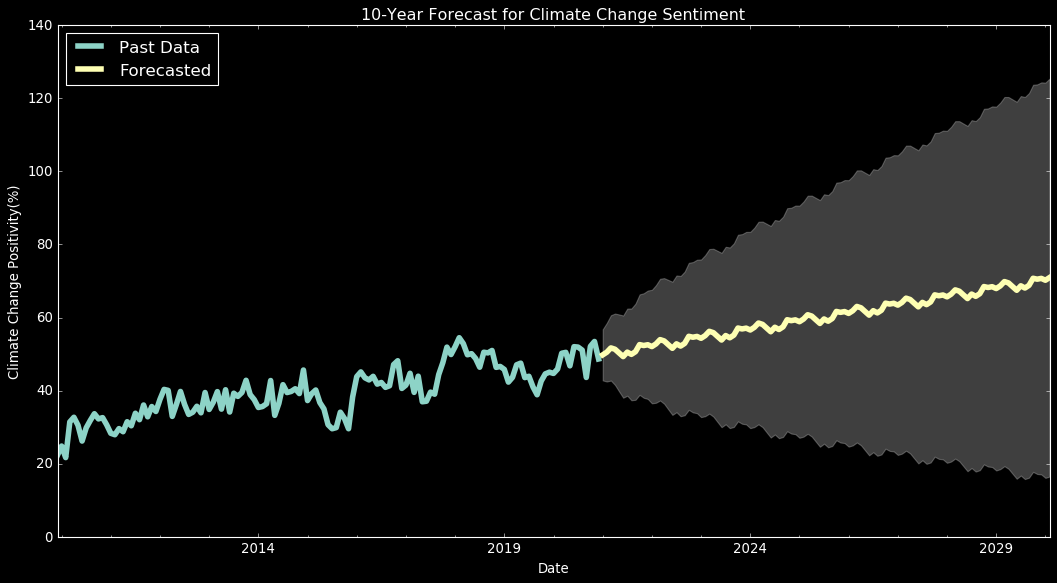

In [34]:
# Creating forcast for next 100 months
pred_uc = results.get_forecast(steps=110)
# Getting 95% confidence interval for forecast
pred_ci = pred_uc.conf_int()

# Plotting forecasts
ax = monthly_mean.plot()
pred_uc.predicted_mean.plot(ax=ax)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='white', alpha=.25)
ax.set_title('10-Year Forecast for Climate Change Sentiment')
ax.set_xlabel('Date')
ax.set_ylabel('Climate Change Positivity(%)')
plt.legend(loc='upper left',fontsize=15, labels=['Past Data', 'Forecasted'])
plt.show()

In [74]:
# Turning forecasts into time series dataframe
forecasted = pd.DataFrame(pred_uc.predicted_mean)
forecasted.index = pd.to_datetime(forecasted.index)
forecasted.columns = ['year_avg']
# Resampling by year
forecasted = forecasted.resample('Y').mean()
# Calculating average growth rate
g = (((forecasted.year_avg[-1] - forecasted.year_avg[0]) / (forecasted.year_avg[0])) / 10) * 100
g = round(g,2)
# Printing growth rate
print('Climate change sentiment positivity % will grow at an average rate of {}% for the next 10 years'.format(g))

Climate change sentiment positivity % will grow at an average rate of 3.84% for the next 10 years


### Time Series Conclusion

There are three parts to this time series analysis above. Therefore, there are three conclusions to be drawn. Keep in mind that all conclusions are based on the assumption that climate change sentiment and donations to the EDF rise in tandom. If this assumption proves to be incorrect, the assumptions that have been drawn below do not hold. They are as follows:

1. There is a clear upward trend in climate change sentiment. Therefore, it is to be expected that donations have also been trending upward in the last 10 years.
2. Climate change sentiment is seasonal. The months where climate change sentiment is above average are: January, February, March, April, October, November and December. The months where climate change sentiment is below average are: May, June, July, August and September. A personal conclusion drawn from these results is that climate change sentiment is higher in the colder months because of the awareness of higher temperature in the last 10 years. Furthermore, the month that the EDF can expect to get the most donations is in March when climate change sentiment is the highest; in August, when climate change sentiment is the lowest, the EDF can expect to receive the fewest donations. 
3. A continuation on the first conclusion, the EDF can expect to see donations go up 3.8% per year over the next 10 years. 

## Geographic Analysis

[Back to Top](#Table-of-Contents)

In [18]:
# json file for us states
state_geo = './applying_classifier/location/data/us-states.json'
# csv for graphing data
geo = pd.read_csv('./applying_classifier/location/data/geographic_plotting_data.csv', index_col=0)
# Checking dataframe
geo.head()

,state,annual_mean_wage,value_of_dollar,value_weighted_wage,sentiment,wage_sent_mult,charitability_score,edf_target_composite_score,num_sent_observations
0,AL,"$44,930",$1.15,51669.5,0.512048,26457.0,56.40,1492174.80,85
1,AK,"$59,290",$0.95,56325.5,0.593750,33443.0,63.41,2120620.63,38
2,AZ,"$50,930",$1.04,52967.2,0.518634,27471.0,46.48,1276852.08,334
3,AR,"$42,690",$1.15,49093.5,0.364865,17912.0,62.16,1113409.92,27
4,CA,"$61,290",$0.87,53322.3,0.543197,28965.0,54.04,1565268.60,2559


### Sentiment

Data for this section was produced using the classifier that can be found in the building classifier portion of this repo. The sentiment for each state was averaged into a single value. 

#### Number of Sentiment Observations Per State

**Graph Explanation**

Folium will be used to plot the number of observations per state. This must be done because there is a pretty severe imablance in number of observations per state for sentiment data. Therefore, the accuracy of states with more observations is likely higher than those with fewer observations.

**Results**

You can see from the image below that the certain states make up a majority of the observations. Therefore, the accuracy of the following states should be weighted above the others when considering sentiment data:
- California
- Washington
- Texas
- Illinois
- Florida
- Pennsylvania
- Massachusetts
- New York

In [19]:
# Initialize the map:
obs = folium.Map(location=[37, -102], zoom_start=3)
 
# Create chloropleth
obs.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=geo,
 columns=['state', 'num_sent_observations'],
 key_on='feature.id',
 fill_color='OrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Number of Observations'
)

# Adding layer
folium.LayerControl().add_to(obs)

# Visualizing obs
obs

#### Average State Sentiment

**Graph Explanation**

Folium will be used to plot the average sentiment per state. This is an average of all -1 (anti man-made) and 1 (man-made) predictions from the classifier. 

**Results**

You can see from the image below that the certain states have higher average sentiment than others. There are many states that fall into the 0.56 - 0.64 range. The most notable observation seems to be vermont, which is the only state that falls into the highest average sentiment range.

In [40]:
# Initialize the map:
sent = folium.Map(location=[37, -102], zoom_start=3)
 
# Create chloropleth
sent.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=geo,
 columns=['state', 'sentiment'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Average Sentiment')

# Adding layer
folium.LayerControl().add_to(sent)

# Visualizing sent
sent

### EDF Target Composite Score

**Graph Explanation**

Folium will be used to plot the EDF Target Composite Score of each state. This score was computed by multiplying the value-weighted wage, average sentiment, and charitability score.

**Results**

There is a range of just under 2 million between states for this value. The graph indicates that the EDF should be more inclined to target the the following two states more than any others:

- Minnesota
- Maryland

In [42]:
# Initialize the map:
edf_score = folium.Map(location=[37, -102], zoom_start=3)
 
# Create chloropleth
edf_score.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=geo,
 columns=['state', 'edf_target_composite_score'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='EDF Target Composite Score')

# Adding layer
folium.LayerControl().add_to(edf_score)

# Visualizing edf_score
edf_score

### Geographic Analysis Conclusion

First and foremost, these results must be accepted along with the fact that the number of observations for sentiment was skewed heavily toward certain states. Therefore, the accuracy for states with the most observations will likely be higher than those with the fewest observations. With that in mind, let's dive into the findings. 

Since the Environmental Defense Fund (EDF) needs a way to cut back on advertising and promotion expenses, the last graphic of the US seems the most appropriate to use. It includes average state sentiment, value-weighted wage, and charitability score all multiplied together for an "EDF Target Composite Score". This score provides the EDF with information on the average disposable income for members of a particular state and their inclination to be charitable with those funds. Additionally, the climate change sentiment multiplier specifies states in which those two values will be the highest for the issue of climate change specifically. 

The top 10 states for the EDF to target given the "EDF Target Composite Score" are:
1. Minnesota
2. Maryland
3. Oregon
4. North Dakota
5. Washington
6. Alaska
7. Vermont
8. Massachusetts
9. New York
10. Maine

# Overall Conclusion

Combining all sections together, the following conclusions can be drawn:

- The classifier is far from perfect. Therefore, the time series and geographic conclusions need to be accepted with caution. 
- The EDF has the opportunity to receive the most donations during March in Minnesota. Therefore, the EDF should heavily consider deploying their advertising and promotion campaings to that location at that time. Apart from that, the EDF will get the most donations during the warm months of the year in the following states:
    - Minnesota
    - Maryland
    - Oregon
    - North Dakota
    - Washington
    - Alaska
    - Vermont
    - Massachusetts
    - New York
    - Maine

## Next Steps

- Create a custom scoring metric that penalizes models more for incorrectly categorizing 'Anti' as 'Man' and vice versa.
- Create a pipline that allows for the time series and geographic analysis to update automatically
- Get location data by county instaead of just by state in order to optimize the geographic analysis